# Imports

In [1]:
# Core
import os
import sys
import ast
import re
import datetime as dt
from typing import List, Dict, Tuple, Any, Optional, Union
import logging
from dataclasses import dataclass, field
import json

# Data analysis
import numpy as np
import pandas as pd

# Visalization
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import seaborn as sns

# Fitting distributions
import scipy.stats
from fitter import Fitter

from statistical_simulation_tools import DistributionFitter, DistributionValidator
from statistical_simulation_tools.utils import *

In [46]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(name="MLB_Fanduel")

# Reading the data

In [3]:
# Helper function to read all the historic dataframes from a path
def read_files(path: str) -> pd.DataFrame:
    files = os.listdir(path)
    files = [os.path.join(path, file) for file in files if re.search(".csv", file)]
    dfs = list(map(lambda file: pd.read_csv(file, low_memory=False), files))
    return pd.concat(dfs)

In [4]:
mlb_df = read_files("../../data/MLB/")

In [5]:
mlb_df.columns

Index(['game_info__bigdataball_dataset', 'game_info__game_id',
       'game_info__date', 'player_info__player_id', 'player_info__player_name',
       'player_info__team', 'player_info__opponent', 'player_info__venue',
       'position__draftkings', 'position__fanduel', 'position__yahoo',
       'salary__draftkings', 'salary__fanduel', 'salary__yahoo',
       'fantasy_points__draftkings', 'fantasy_points__fanduel',
       'fantasy_points__yahoo'],
      dtype='object')

In [6]:
mlb_df.dtypes

game_info__bigdataball_dataset     object
game_info__game_id                 object
game_info__date                    object
player_info__player_id            float64
player_info__player_name           object
player_info__team                  object
player_info__opponent              object
player_info__venue                 object
position__draftkings               object
position__fanduel                  object
position__yahoo                    object
salary__draftkings                 object
salary__fanduel                   float64
salary__yahoo                     float64
fantasy_points__draftkings         object
fantasy_points__fanduel            object
fantasy_points__yahoo              object
dtype: object

# Cleaning data

In [7]:
mlb_df.game_info__bigdataball_dataset.value_counts()

game_info__bigdataball_dataset
MLB 2019 Regular Season    71681
MLB 2021 Regular Season    71619
MLB 2022 Regular Season    70931
MLB 2020 Regular Season    26720
MLB 2020 Playoffs           1692
MLB 2021 Playoffs           1213
MLB 2022 Playoffs           1207
MLB 2019 Playoffs           1138
Name: count, dtype: int64

In [8]:
def with_season_type(game_type: str) -> str:
    return "regular-season" if re.search("Season", game_type) else "playoffs"

In [9]:
def format_date(date_str: str) -> dt.datetime:
    try:
        _date = dt.datetime.strptime(date_str, "%d/%m/%Y")
    except ValueError:
        _date = dt.datetime.strptime(date_str, "%m/%d/%Y")
    return _date

In [10]:
cleaned_mlb_df = mlb_df.assign(
    game_info__date=pd.to_datetime(mlb_df.game_info__date.apply(format_date)),
    fantasy_points__draftkings=mlb_df.fantasy_points__draftkings.apply(lambda s: float(str(s).replace(",","."))),
    fantasy_points__fanduel=mlb_df.fantasy_points__fanduel.apply(lambda s: float(str(s).replace(",","."))),
    fantasy_points__yahoo=mlb_df.fantasy_points__yahoo.apply(lambda s: float(str(s).replace(",","."))),
    game_info__game_type=mlb_df.game_info__bigdataball_dataset.apply(with_season_type)
).pipe(lambda df: df.assign(
    year=df['game_info__date'].dt.year
))

# Fitting distributions

## By player

In [11]:
def get_frequencies(df: pd.DataFrame, groupby_keys: List[str]) -> pd.DataFrame:
    frequency_df = df.groupby(groupby_keys).size().reset_index(name='frequency')
    frequency_df = frequency_df.sort_values(by=['frequency'], ascending=False)
    return frequency_df

In [238]:
def plot_distribution_by_variable(df: pd.DataFrame, variable: str, xlabel: str, ylabel: str) -> None:
    
    fig, ax = plt.subplots(ncols=2, figsize=(20, 6))
    
    sns.histplot(data=df, x=variable, kde=True, ax=ax[0])
    ax[0].set_ylabel(ylabel)
    ax[0].set_xlabel(xlabel)
    
    sns.boxplot(data=df, x=variable, orient='h', ax=ax[1])
    sns.stripplot(data=df, x=variable, orient='h', color=".25", ax=ax[1])
    
    ax[1].tick_params(axis='y', which='both', left=False, top=False, labelleft=False)
    ax[1].set_xlabel(xlabel)
    
    fig.suptitle(f'Distribution of: {xlabel.lower()} by {ylabel.lower()}')
    
    plt.plot();

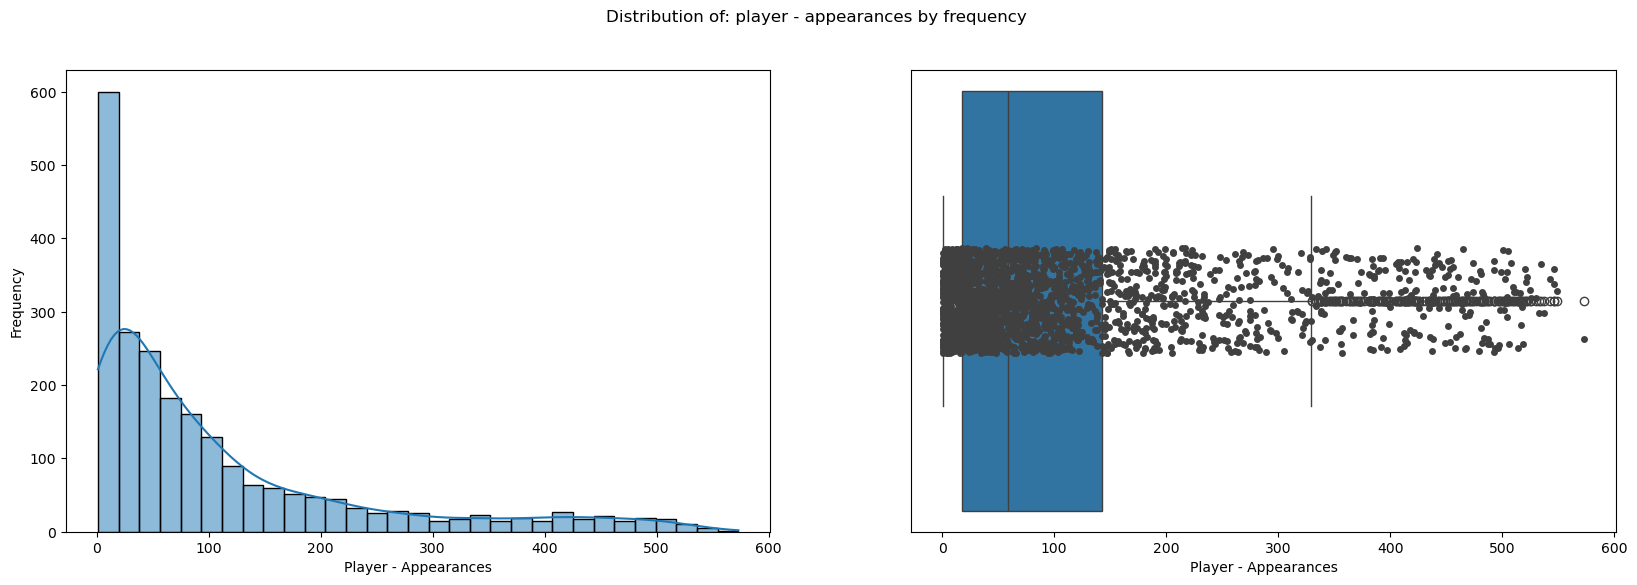

In [13]:
plot_distribution_by_variable(get_frequencies(cleaned_mlb_df, ["player_info__player_id"]), "frequency", "Player - Appearances", "Frequency")

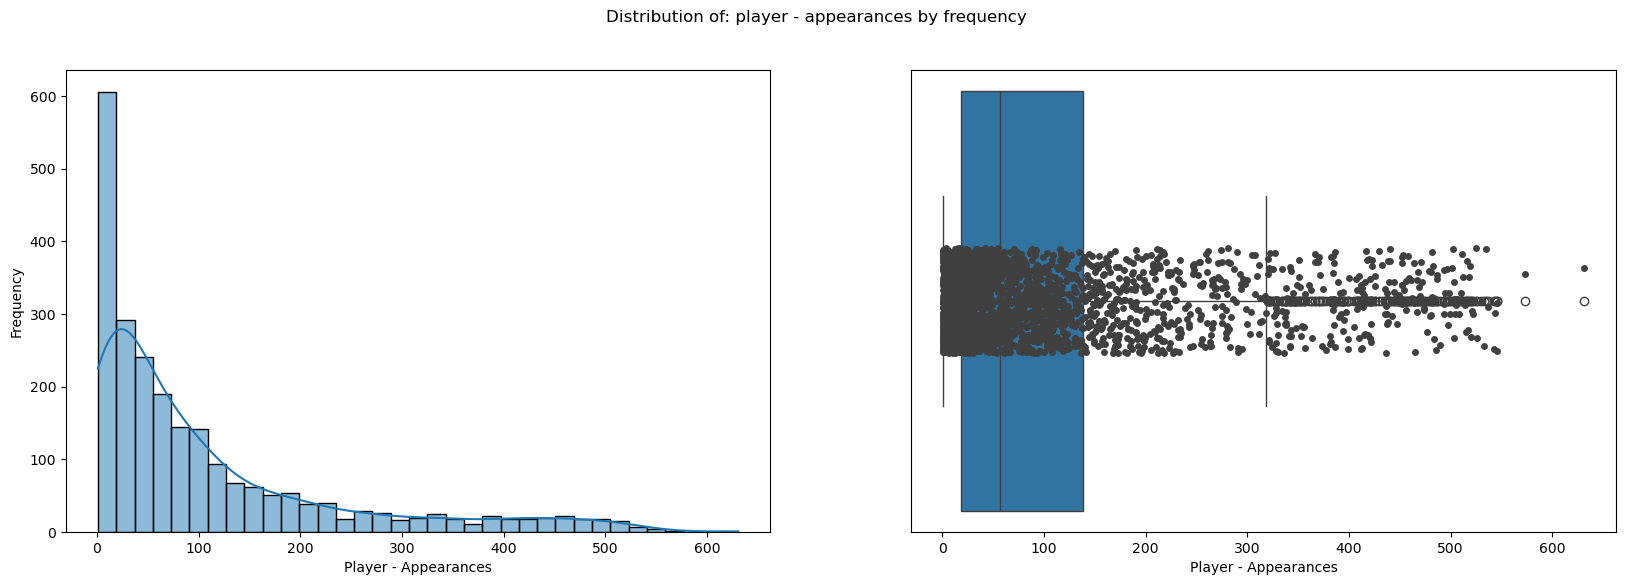

In [14]:
plot_distribution_by_variable(get_frequencies(cleaned_mlb_df, ["player_info__player_name"]), "frequency", "Player - Appearances", "Frequency")

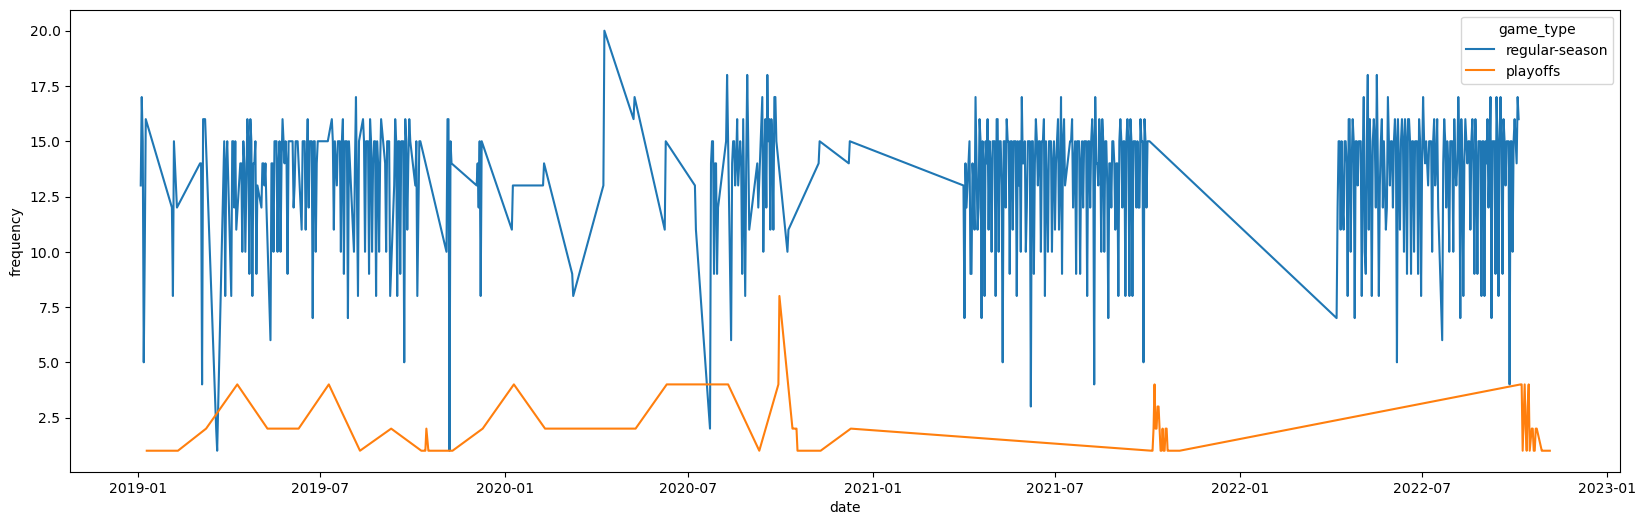

In [15]:
games_per_date = cleaned_mlb_df[["game_info__game_type", "game_info__game_id", "game_info__date"]].drop_duplicates()\
.groupby(["game_info__date", "game_info__game_type"])\
.size()\
.reset_index(name='frequency')\
.rename(columns={"game_info__date": "date", "game_info__game_type": "game_type"})

fig, ax = plt.subplots(figsize=(20, 6))

sns.lineplot(
    data=games_per_date,
    x="date",
    y="frequency",
    hue="game_type",
    ax=ax
)

plt.plot();

In [16]:
def plot_histogram(
    df: pd.DataFrame, 
    filter_column: str, 
    factor: Any, 
    value: str,
    kde: bool = False
) -> Figure:
    fig, ax = plt.subplots(ncols=1, figsize=(16, 8))

    sns.histplot(
        data=df[
        (df[filter_column] == factor) & (~df[value].isna())
        ], 
        x=value, 
        kde=kde,
        bins=100
    )
    ax.set_ylabel('Frecuency')
    ax.set_xlabel(" - ".join(value.split("__")))

    fig.suptitle(f'Distribution of: {value} by factor: {factor}')

    return fig

## Position

In [29]:
get_frequencies(cleaned_mlb_df, ["position__fanduel"]).sort_values(by=["frequency"], ascending=False).reset_index(drop=True)

position__fanduel  frequency
0                  P      69587
1                 OF      58807
2                  C      19887
3                 1B      17444
4                 SS      15615
5                 3B      15597
6                 2B      14718
7              2B/SS       4035
8              2B/OF       2877
9              3B/2B       2163
10             1B/OF       1862
11               C1B       1443
12             3B/SS       1122
13             2B/3B       1109
14             3B/1B       1085
15             1B/2B        828
16             3B/OF        756
17             SS/3B        662
18             SS/OF        656
19             SS/2B        546
20             1B/3B        534
21          3B/SS/2B        320
22          2B/SS/3B        261
23          SS/3B/2B        256
24          1B/2B/3B        245
25            C1B/OF        184
26             OF/3B        142
27              OF/C        127
28             OF/1B         99
29          2B/1B/3B         97
30              C/OF         94
31            C1B/2B         93
32            C1B/3B         87
33             OF/SS         78
34             OF/2B         72
35          2B/3B/SS         72
36          OF/3B/2B         62
37          3B/SS/OF         60
38          3B/2B/SS         52
39          3B/2B/1B         47
40          1B/3B/2B         46
41          OF/2B/SS         26
42            OF/C1B         22
43           OF/CC1B         22
44            2B/C1B         20
45          2B/C1B/3         19
46              C/1B         18
47             2B/1B         18
48             1B/SS         16
49           CC1B/OF         15
50          1B/3B/OF         15
51          CC1B/C1B         13
52          1B/2B/SS         12
53          C1B/2B/S          9
54                 0          3
55              5500          2
56              C/CC          1
57              5700          1

# Distributions fitting process

## P - Pitchers

In [22]:
cleaned_mlb_df.head()

game_info__bigdataball_dataset game_info__game_id game_info__date  \
0        MLB 2022 Regular Season    44658-MIL@CHC-1      2022-04-07   
1        MLB 2022 Regular Season    44658-MIL@CHC-1      2022-04-07   
2        MLB 2022 Regular Season    44658-MIL@CHC-1      2022-04-07   
3        MLB 2022 Regular Season    44658-MIL@CHC-1      2022-04-07   
4        MLB 2022 Regular Season    44658-MIL@CHC-1      2022-04-07   

   player_info__player_id player_info__player_name  player_info__team  \
0                543939.0              Kolten Wong  Milwaukee Brewers   
1                642715.0             Willy Adames  Milwaukee Brewers   
2                592885.0         Christian Yelich  Milwaukee Brewers   
3                457705.0         Andrew McCutchen  Milwaukee Brewers   
4                642133.0             Rowdy Tellez  Milwaukee Brewers   

  player_info__opponent player_info__venue position__draftkings  \
0          Chicago Cubs               Road                  NaN   
1          Chicago Cubs               Road                  NaN   
2          Chicago Cubs               Road                  NaN   
3          Chicago Cubs               Road                  NaN   
4          Chicago Cubs               Road                  NaN   

  position__fanduel position__yahoo salary__draftkings  salary__fanduel  \
0                2B             NaN                NaN           2600.0   
1                SS             NaN                NaN           2900.0   
2                OF             NaN                NaN           3300.0   
3                OF             NaN                NaN           2500.0   
4               C1B             NaN                NaN           2200.0   

   salary__yahoo  fantasy_points__draftkings  fantasy_points__fanduel  \
0            NaN                         NaN                      6.2   
1            NaN                         NaN                     12.5   
2            NaN                         NaN                      6.5   
3            NaN                         NaN                     12.2   
4            NaN                         NaN                      9.2   

   fantasy_points__yahoo game_info__game_type  year  
0                    NaN       regular-season  2022  
1                    NaN       regular-season  2022  
2                    NaN       regular-season  2022  
3                    NaN       regular-season  2022  
4                    NaN       regular-season  2022

In [94]:
pitchers_df = cleaned_mlb_df[
    (cleaned_mlb_df.position__fanduel == "P") & 
    (~cleaned_mlb_df['fantasy_points__fanduel'].isna())
    ]

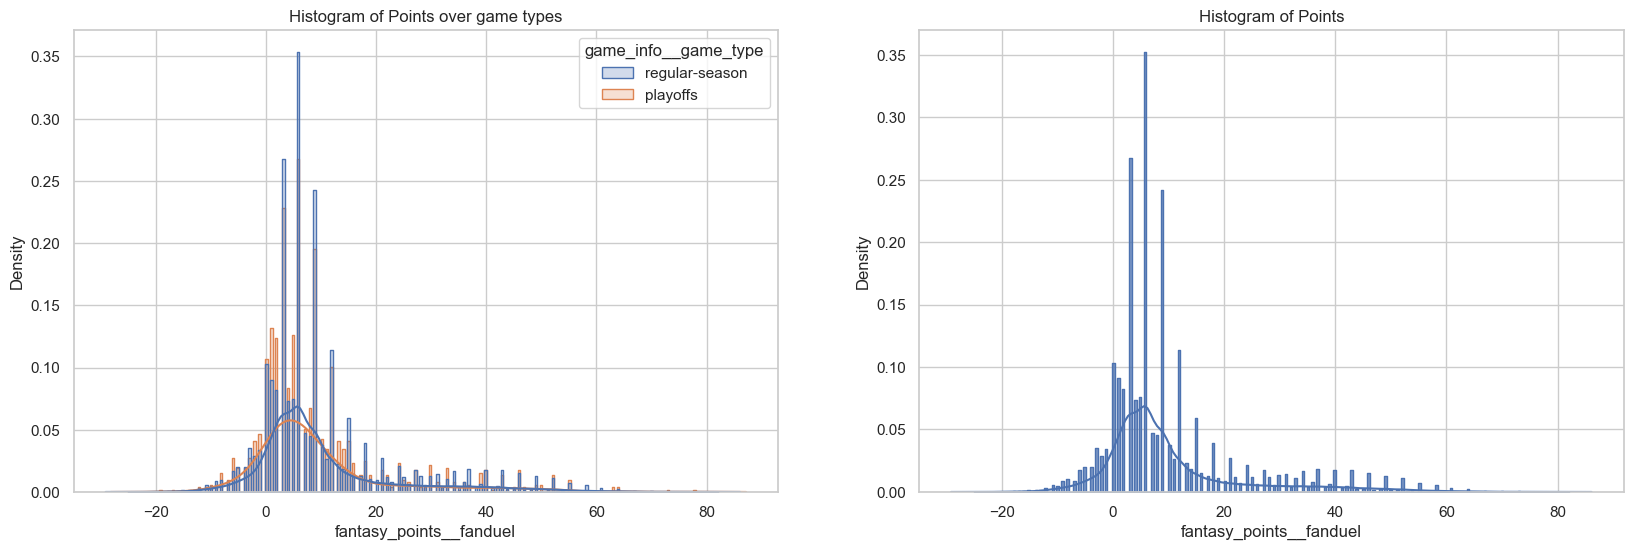

In [95]:
# Setting up style for better visualization
sns.set(style="whitegrid")

# Plotting the histogram
fig, ax = plt.subplots(ncols=2, figsize=(20, 6))

sns.kdeplot(
    data=pitchers_df, 
    x='fantasy_points__fanduel', 
    hue='game_info__game_type', 
    common_norm=False,
    ax=ax[0]
)

sns.histplot(
    data=pitchers_df, 
    x='fantasy_points__fanduel', 
    hue='game_info__game_type', 
    element='step', 
    stat='density', 
    common_norm=False,
    ax=ax[0]
)

ax[0].set_title("Histogram of Points over game types")

sns.kdeplot(
    data=pitchers_df, 
    x='fantasy_points__fanduel',  
    common_norm=False,
    ax=ax[1]
)

sns.histplot(
    data=pitchers_df, 
    x='fantasy_points__fanduel', 
    element='step', 
    stat='density', 
    common_norm=False,
    ax=ax[1]
)

ax[1].set_title('Histogram of Points')

plt.show()

### Adding more variables for categorizing players and don't assume a general distribution

In [96]:
statistics_by_pitcher = pitchers_df\
.groupby('player_info__player_id')\
.agg(number_of_observations=pd.NamedAgg("player_info__player_id", "count"))\
.sort_values(by=['number_of_observations'])\
.pipe(lambda df: df.assign(
    cumsum_observations=df.number_of_observations.cumsum(), 
    total_observations=df.number_of_observations.sum()
))\
.pipe(lambda df: df.assign(
    cumulative_proportion=(df.cumsum_observations / df.total_observations) * 100))\
.reset_index()\
.pipe(lambda df: df.assign(
    decile_group=pd.cut(df.cumulative_proportion, bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]).astype("str")
))

In [97]:
pitchers_df = pitchers_df.merge(right=statistics_by_pitcher)

In [98]:
pitchers_df.head()

game_info__bigdataball_dataset game_info__game_id game_info__date  \
0        MLB 2022 Regular Season    44658-MIL@CHC-1      2022-04-07   
1        MLB 2022 Regular Season    44664-MIL@BAL-1      2022-04-13   
2        MLB 2022 Regular Season    44670-PIT@MIL-1      2022-04-19   
3        MLB 2022 Regular Season    44676-SFG@MIL-1      2022-04-25   
4        MLB 2022 Regular Season    44682-CHC@MIL-1      2022-05-01   

   player_info__player_id player_info__player_name  player_info__team  \
0                669203.0            Corbin Burnes  Milwaukee Brewers   
1                669203.0            Corbin Burnes  Milwaukee Brewers   
2                669203.0            Corbin Burnes  Milwaukee Brewers   
3                669203.0            Corbin Burnes  Milwaukee Brewers   
4                669203.0            Corbin Burnes  Milwaukee Brewers   

  player_info__opponent player_info__venue position__draftkings  \
0          Chicago Cubs               Road                  NaN   
1     Baltimore Orioles               Road                  NaN   
2    Pittsburgh Pirates               Home                    P   
3  San Francisco Giants               Home                    P   
4          Chicago Cubs               Home                    P   

  position__fanduel  ... fantasy_points__draftkings fantasy_points__fanduel  \
0                 P  ...                        NaN                    18.0   
1                 P  ...                        NaN                    49.0   
2                 P  ...                      33.35                    55.0   
3                 P  ...                      34.00                    57.0   
4                 P  ...                      28.75                    49.0   

   fantasy_points__yahoo  game_info__game_type  year  number_of_observations  \
0                    NaN        regular-season  2022                     105   
1                   32.5        regular-season  2022                     105   
2                   37.4        regular-season  2022                     105   
3                    NaN        regular-season  2022                     105   
4                   32.5        regular-season  2022                     105   

   cumsum_observations total_observations  cumulative_proportion  decile_group  
0                40565              69587              58.293934      (50, 60]  
1                40565              69587              58.293934      (50, 60]  
2                40565              69587              58.293934      (50, 60]  
3                40565              69587              58.293934      (50, 60]  
4                40565              69587              58.293934      (50, 60]  

[5 rows x 24 columns]

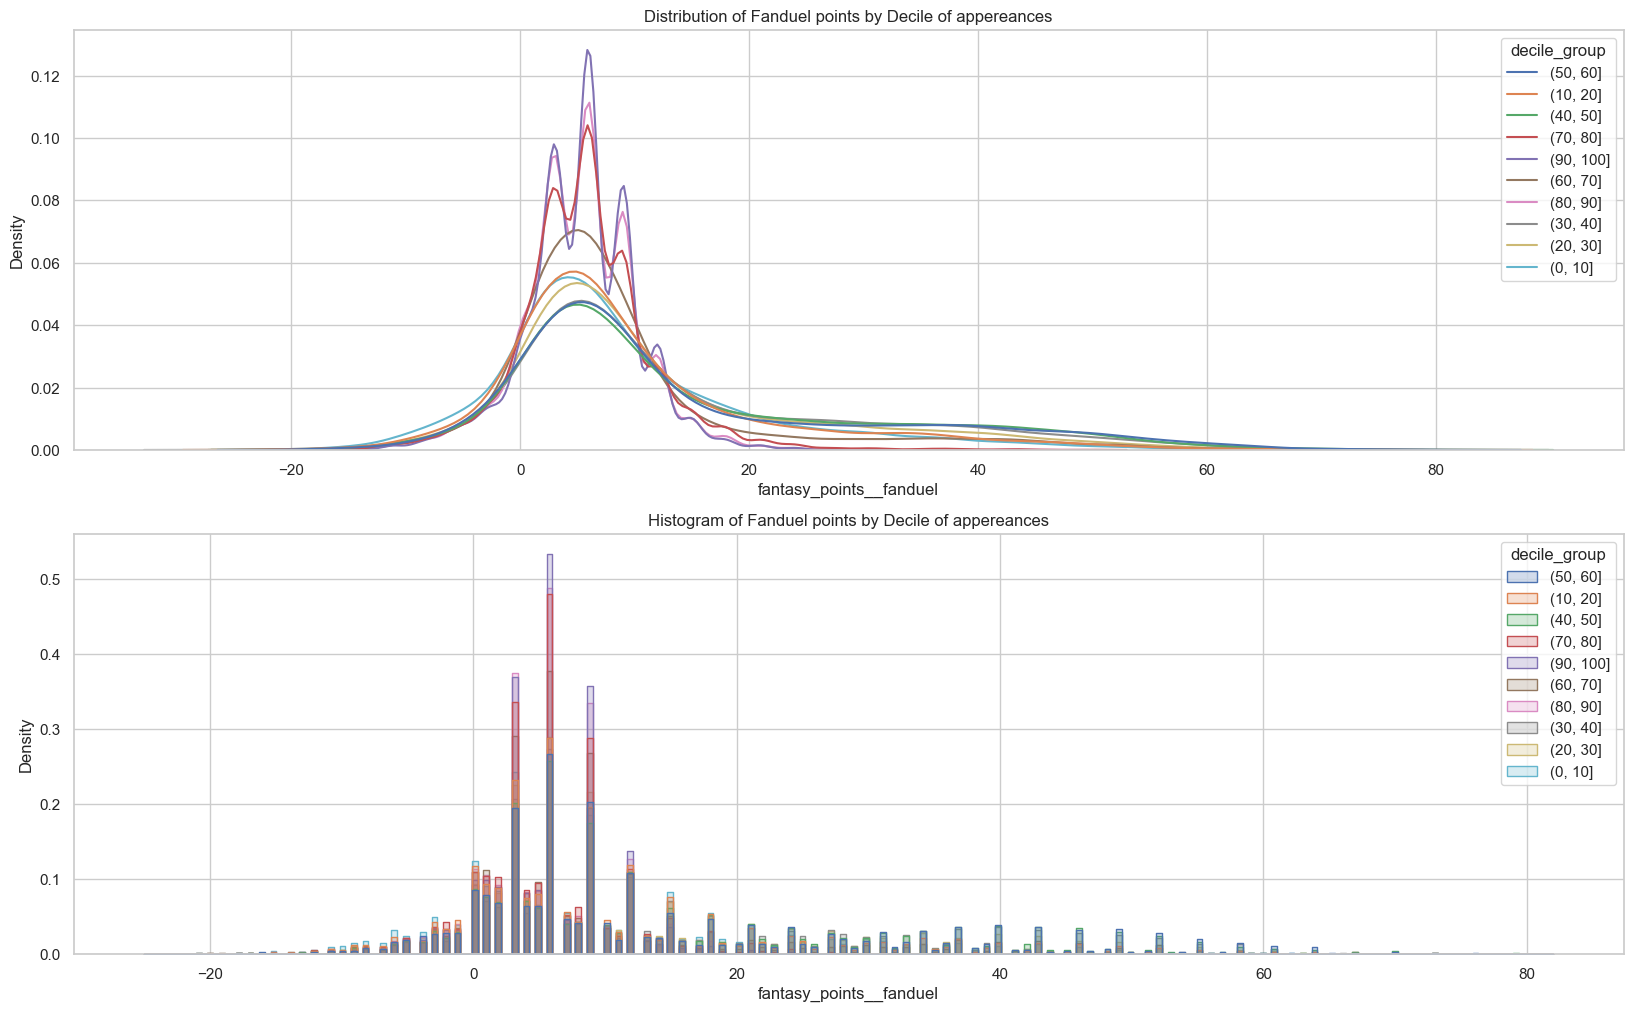

In [99]:
fig, ax = plt.subplots(nrows=2, figsize=(20, 12))

sns.kdeplot(
    data=pitchers_df, 
    x='fantasy_points__fanduel', 
    hue='decile_group', 
    common_norm=False,
    ax=ax[0],
)

ax[0].set_title('Distribution of Fanduel points by Decile of appereances')

sns.histplot(
    data=pitchers_df, 
    x='fantasy_points__fanduel', 
    element='step', 
    stat='density', 
    hue='decile_group', 
    common_norm=False, # Helps on visualization,
    ax=ax[1]
)

ax[1].set_title('Histogram of Fanduel points by Decile of appereances')

plt.show()

### Fitting a general distribution for all the population of pitchers

#### Fitting

In [100]:
data = pitchers_df['fantasy_points__fanduel']

In [101]:
pitchers_distribution_fitter = DistributionFitter(
    distributions=[dist for dist in get_distributions() if dist not in ["levy_stable", "studentized_range", "erlang", "lognorm", "loguniform"]], 
    bins=sturges_bins(data)
)

In [102]:
pitchers_distribution_fitter.fit(data)

INFO:statistical_simulation_tools.distribution_fitter:Fitting distribution: alpha
INFO:statistical_simulation_tools.distribution_fitter:Fitting distribution: anglit
INFO:statistical_simulation_tools.distribution_fitter:Fitting distribution: arcsine
INFO:statistical_simulation_tools.distribution_fitter:Fitting distribution: argus
INFO:statistical_simulation_tools.distribution_fitter:Fitting distribution: beta
/opt/miniconda3/envs/statistical-simulation/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:719: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
INFO:statistical_simulation_tools.distribution_fitter:Fitting distribution: betaprime
INFO:statistical_simulation_tools.distribution_fitter:Fitting distribution: bradford
INFO:statistical_simulation_tools.distribution_fitter:Fitting distribution: burr
INFO:statistical_simulation_tools.distribution_fitter:Fitting distribution: burr12
INFO:statistical_simulation_t

In [103]:
pitchers_distribution_fitter.summary(sort_by="ks_statistic", top_n=15)

distribution  squared_error          aic  \
johnsonsu                    johnsonsu       0.279654  3237.817601   
norminvgauss              norminvgauss       0.279139  3265.040498   
nct                                nct       0.279995  3265.547253   
genhyperbolic            genhyperbolic       0.279457  3230.866132   
skewcauchy                  skewcauchy       0.279372  3145.885595   
loglaplace                  loglaplace       0.277658  3472.183515   
t                                    t       0.280463  3319.723631   
tukeylambda                tukeylambda       0.280360  3312.670860   
burr                              burr       0.287806  3777.436761   
laplace_asymmetric  laplace_asymmetric       0.281542  3381.880227   
fisk                              fisk       0.289553  3633.896662   
dgamma                          dgamma       0.196144  3435.714930   
mielke                          mielke       0.288658  3619.629916   
hypsecant                    hypsecant       0.293892  3645.202586   
cauchy                          cauchy       0.279698  3233.652377   

                            bic  kullberg_divergence  ks_statistic  \
johnsonsu           3274.418934                  inf      0.077089   
norminvgauss        3301.641831                  inf      0.078111   
nct                 3302.148585                  inf      0.080681   
genhyperbolic       3276.617797                  inf      0.081184   
skewcauchy          3173.336594                  inf      0.092572   
loglaplace          3499.634514                  inf      0.108121   
t                   3347.174630                  inf      0.109933   
tukeylambda         3340.121859                  inf      0.111245   
burr                3814.038093                  inf      0.115516   
laplace_asymmetric  3409.331226                  inf      0.115773   
fisk                3661.347661                  inf      0.115809   
dgamma              3463.165929                  inf      0.119684   
mielke              3656.231248                  inf      0.121813   
hypsecant           3663.503252                  inf      0.126328   
cauchy              3251.953044                  inf      0.127441   

                    ks_p_value  \
johnsonsu                  0.0   
norminvgauss               0.0   
nct                        0.0   
genhyperbolic              0.0   
skewcauchy                 0.0   
loglaplace                 0.0   
t                          0.0   
tukeylambda                0.0   
burr                       0.0   
laplace_asymmetric         0.0   
fisk                       0.0   
dgamma                     0.0   
mielke                     0.0   
hypsecant                  0.0   
cauchy                     0.0   

                                                        fitted_params  
johnsonsu           {'a': -0.7427241888177314, 'b': 0.872681705728...  
norminvgauss        {'a': 0.5081836267007738, 'b': 0.3915655691558...  
nct                 {'df': 1.8321062249827091, 'nc': 1.20907318347...  
genhyperbolic       {'p': -0.009442170205702916, 'a': 0.3509869978...  
skewcauchy          {'a': 0.44363369918345535, 'loc': 3.2209192815...  
loglaplace          {'c': 4.555453459282299, 'loc': -25.0372301810...  
t                   {'df': 1.4680507180806637, 'loc': 5.9808390853...  
tukeylambda         {'lam': -0.5621319691124701, 'loc': 5.96266076...  
burr                {'c': 5.352801267512225, 'd': 1.95130585199655...  
laplace_asymmetric  {'kappa': 0.5858184617584932, 'loc': 2.9999999...  
fisk                {'c': 6.048880444513632, 'loc': -25.0379189151...  
dgamma              {'a': 0.6901840458063504, 'loc': 6.00000000000...  
mielke              {'k': 15.115032347580875, 's': 6.6563766164219...  
hypsecant           {'loc': 7.271812502662096, 'scale': 6.95492262...  
cauchy              {'loc': 5.771474372662453, 'scale': 4.08038378...

#### Validation

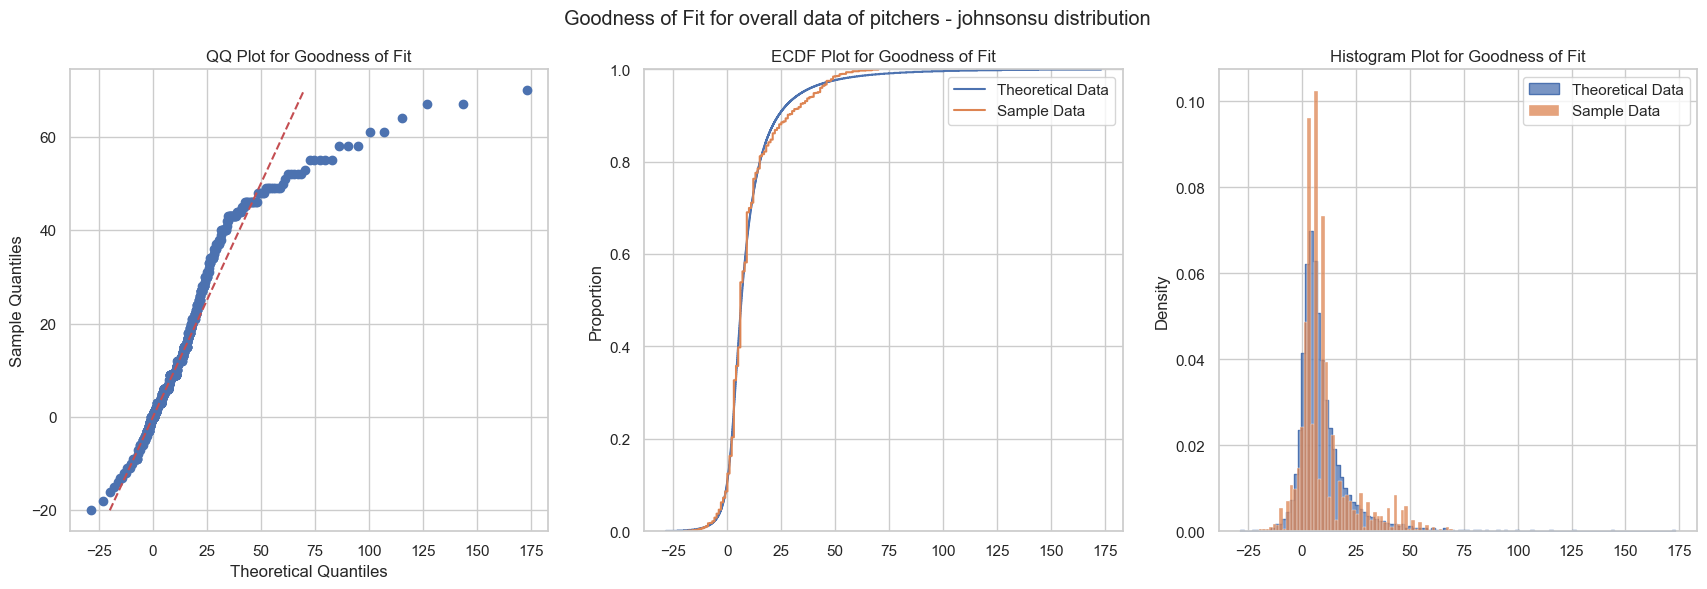

In [104]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=pitchers_distribution_fitter, 
    distribution_name="johnsonsu", 
    sample_proportion=0.02, 
    suptitle="Goodness of Fit for overall data of pitchers - johnsonsu distribution"
)

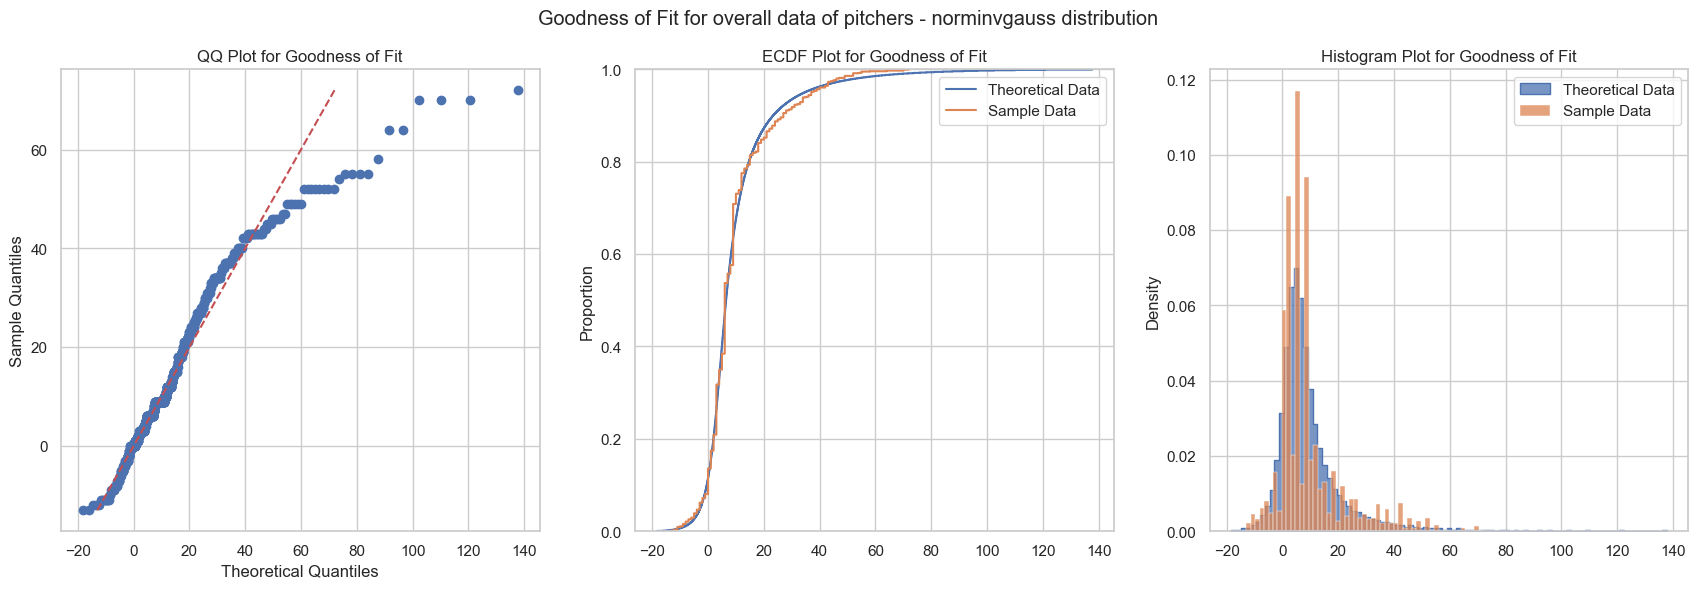

In [105]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=pitchers_distribution_fitter, 
    distribution_name="norminvgauss", 
    sample_proportion=0.02, 
    suptitle="Goodness of Fit for overall data of pitchers - norminvgauss distribution"
)

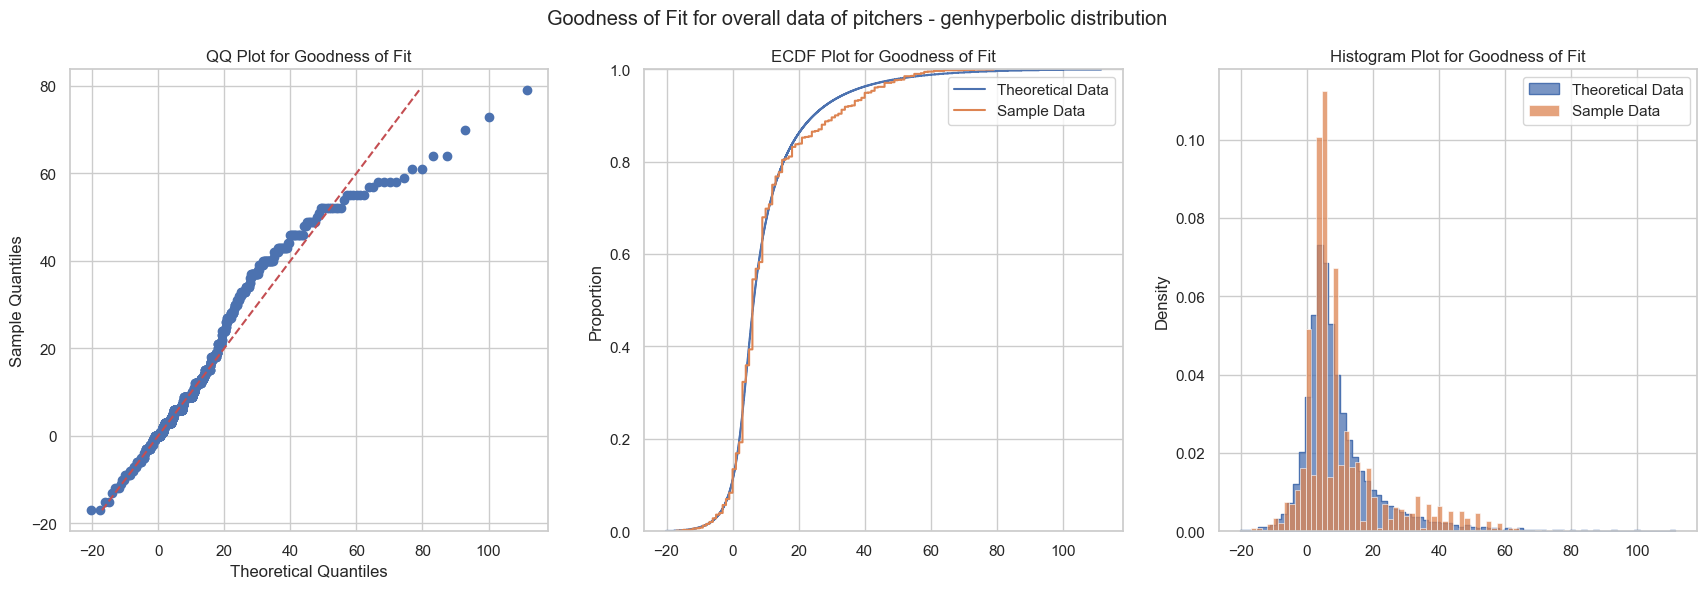

In [106]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=pitchers_distribution_fitter, 
    distribution_name="genhyperbolic", 
    sample_proportion=0.02, 
    suptitle="Goodness of Fit for overall data of pitchers - genhyperbolic distribution"
)

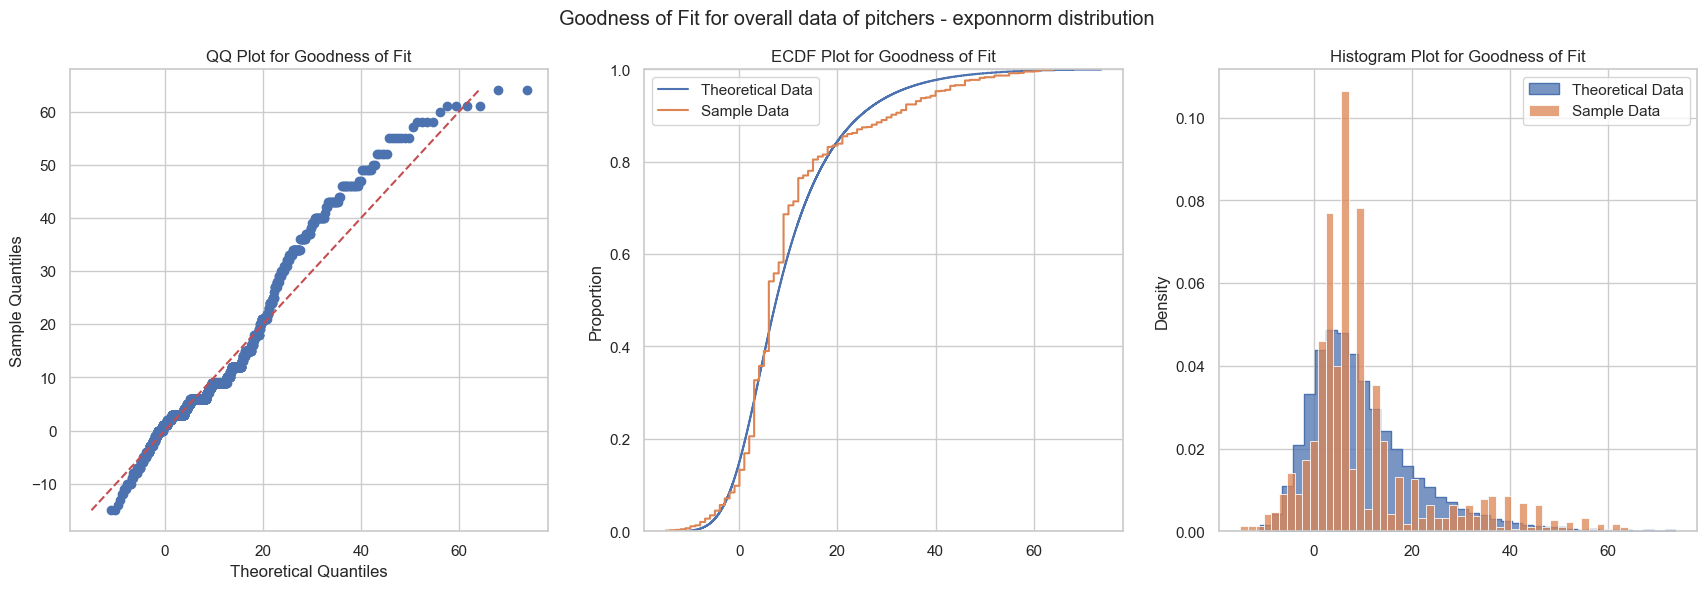

In [107]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=pitchers_distribution_fitter, 
    distribution_name="exponnorm", 
    sample_proportion=0.02, 
    suptitle="Goodness of Fit for overall data of pitchers - exponnorm distribution"
)

### Fitting a distribution by decile

#### Fitting

In [108]:
deciles_groups = pitchers_df.decile_group.unique()

fitters = {}

for decile_group in deciles_groups:

    filtered_data = pitchers_df[pitchers_df.decile_group == decile_group]['fantasy_points__fanduel']
    
    fitter = DistributionFitter(
        distributions=["exponnorm", "genhyperbolic", "norminvgauss", "johnsonsu"],
        bins=sturges_bins(filtered_data)
    )

    logger.info(f"fitting {decile_group}")

    fitter.fit(filtered_data)

    fitters[decile_group] = fitter

INFO:MLB_Fanduel:fitting (50, 60]
INFO:statistical_simulation_tools.distribution_fitter:Fitting distribution: exponnorm
INFO:statistical_simulation_tools.distribution_fitter:Fitting distribution: genhyperbolic
/opt/miniconda3/envs/statistical-simulation/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:3759: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intgrl = integrate.quad(llc, x0, x1,
/opt/miniconda3/envs/statistical-simulation/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:3754: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intgrl = (integrate.quad(llc, x0, mean,
INFO:statistical_simulation_tools.distribution_fitter:Fitting distribution: norminvgauss
INFO:statistical_simulation_tools.distribution_fitter:Fitting distribution: johnsonsu
INFO:MLB_Fanduel:fitting (10, 20]
INFO:statistical_simulation_tools.distribution_fitter:Fitting distribution: exponnorm
INFO:statistical_simulation_tools.

#### Validation

##### **Decile 10%**

In [109]:
fitters['(0, 10]'].summary(sort_by="ks_statistic")

distribution  squared_error         aic          bic  \
norminvgauss    norminvgauss       0.013380  950.212221   977.584949   
johnsonsu          johnsonsu       0.013352  950.607915   977.980644   
exponnorm          exponnorm       0.014886  981.566801  1002.096347   
genhyperbolic  genhyperbolic       0.012755  945.958036   980.173946   

               kullberg_divergence  ks_statistic    ks_p_value  \
norminvgauss                   inf      0.065842  1.492459e-26   
johnsonsu                      inf      0.068407  1.251912e-28   
exponnorm                      inf      0.083314  2.819903e-42   
genhyperbolic                  inf      0.664790  0.000000e+00   

                                                   fitted_params  
norminvgauss   {'a': 0.8362802634740207, 'b': 0.5426087912854...  
johnsonsu      {'a': -0.794525974980381, 'b': 1.1160020287426...  
exponnorm      {'K': 1.936953865172137, 'loc': -1.15432286206...  
genhyperbolic  {'p': 0.7784130599658367, 'a': 3.7848095895524...

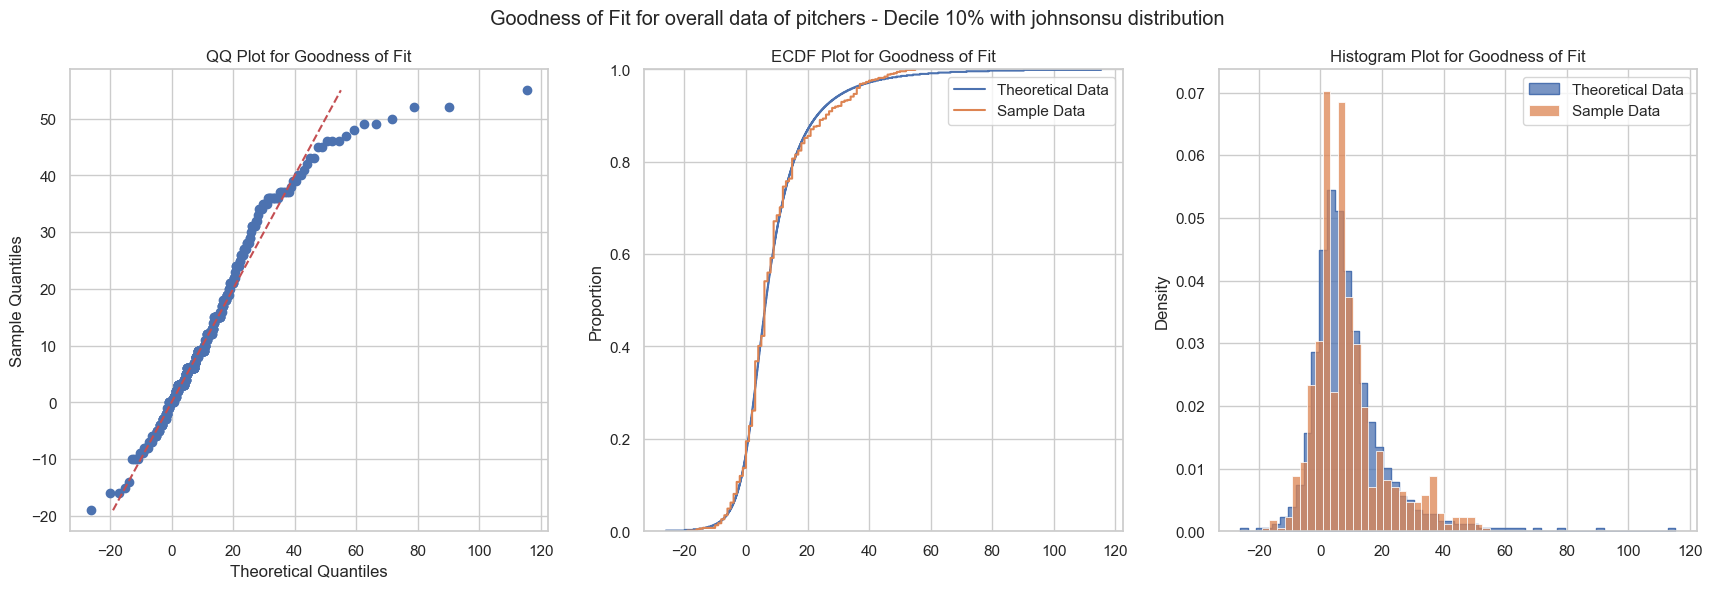

In [110]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(0, 10]'], 
    distribution_name="johnsonsu", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 10% with johnsonsu distribution"
)

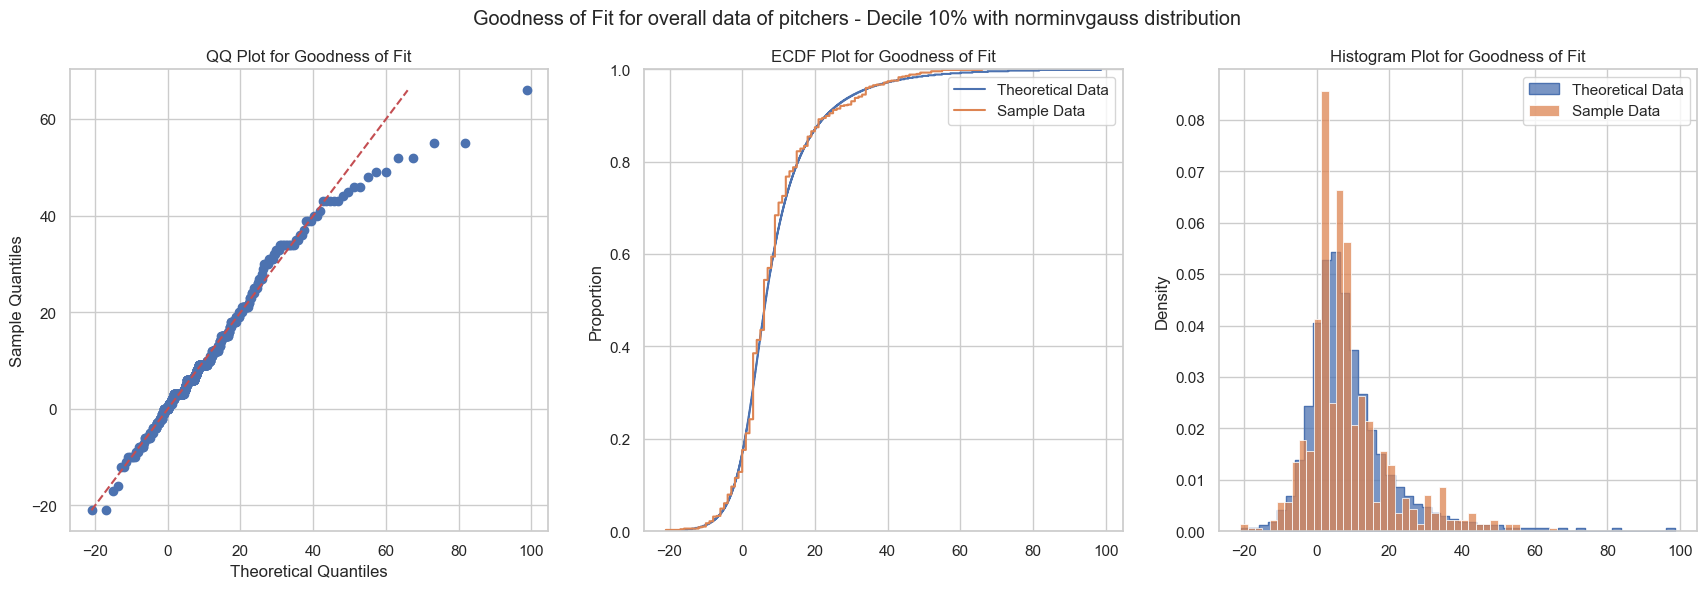

In [111]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(0, 10]'], 
    distribution_name="norminvgauss", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 10% with norminvgauss distribution"
)

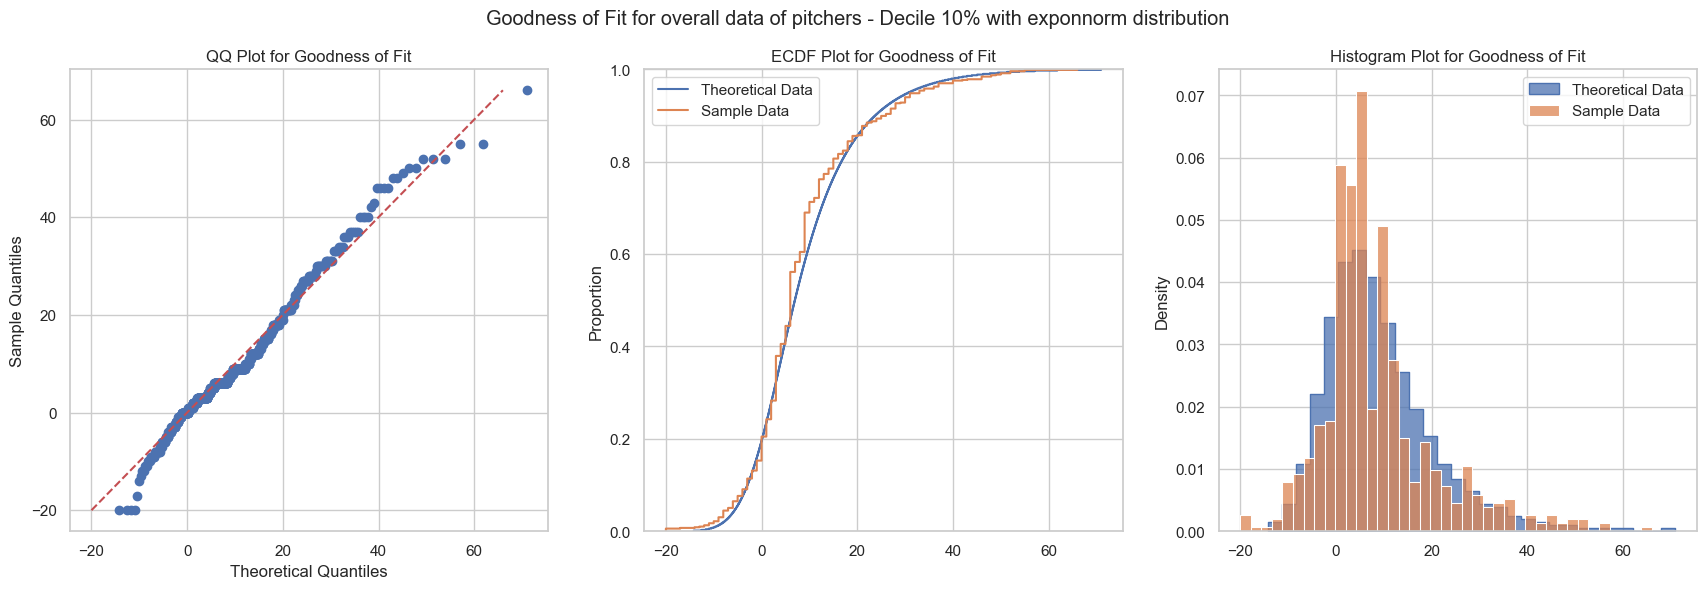

In [112]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(0, 10]'], 
    distribution_name="exponnorm", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 10% with exponnorm distribution"
)

##### **Decile 20%**

In [113]:
fitters['(10, 20]'].summary(sort_by="ks_statistic", top_n=10)

distribution  squared_error          aic          bic  \
genhyperbolic  genhyperbolic       0.011055  1018.333770  1052.561937   
norminvgauss    norminvgauss       0.010908  1022.512274  1049.894807   
johnsonsu          johnsonsu       0.010877  1018.593931  1045.976464   
exponnorm          exponnorm       0.012298  1099.160238  1119.697137   

               kullberg_divergence  ks_statistic    ks_p_value  \
genhyperbolic                  inf      0.065598  2.011593e-26   
norminvgauss                   inf      0.066922  1.751240e-27   
johnsonsu                      inf      0.068447  9.889764e-29   
exponnorm                      inf      0.098250  8.441960e-59   

                                                   fitted_params  
genhyperbolic  {'p': 0.2971109297012276, 'a': 0.3618521065009...  
norminvgauss   {'a': 0.6908131804666189, 'b': 0.5101328457161...  
johnsonsu      {'a': -0.8285819684379214, 'b': 0.975066643251...  
exponnorm      {'K': 2.2897844174723714, 'loc': -0.9313829443...

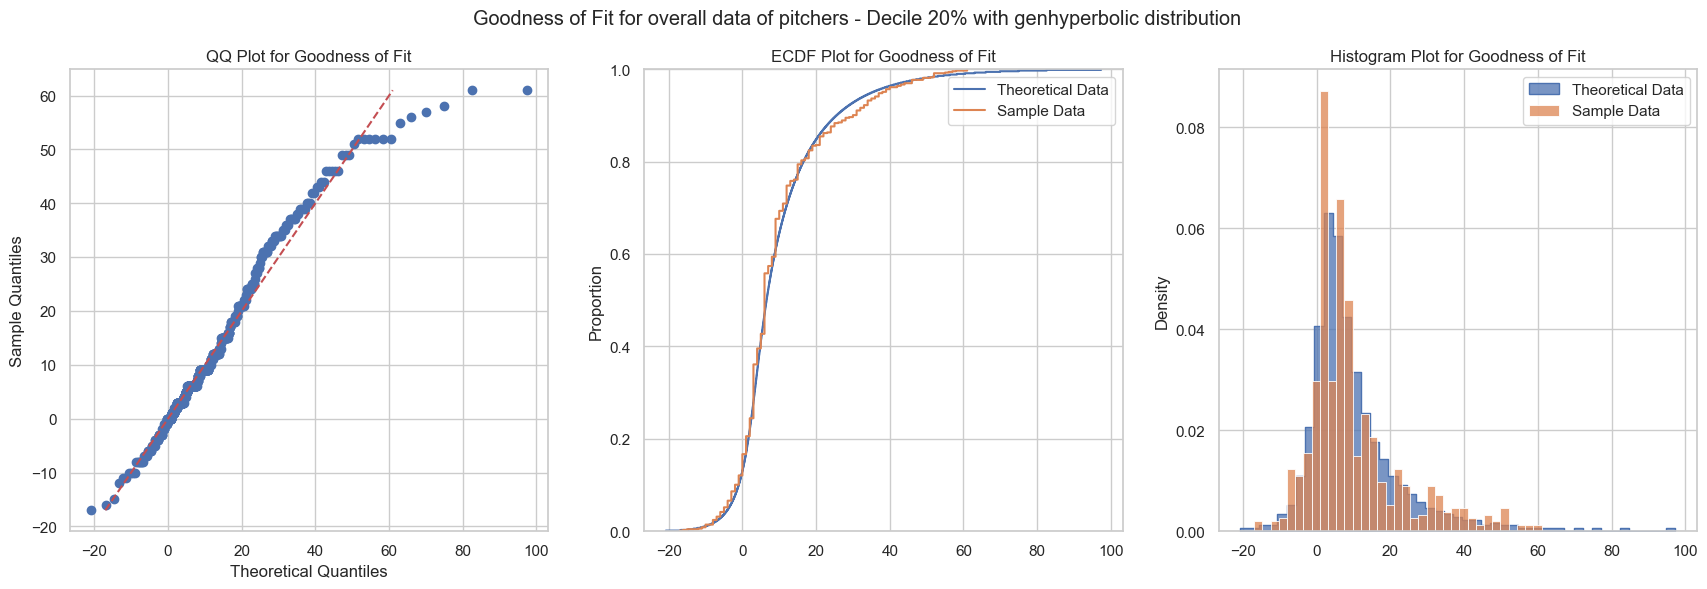

In [114]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(10, 20]'], 
    distribution_name="genhyperbolic", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 20% with genhyperbolic distribution"
)

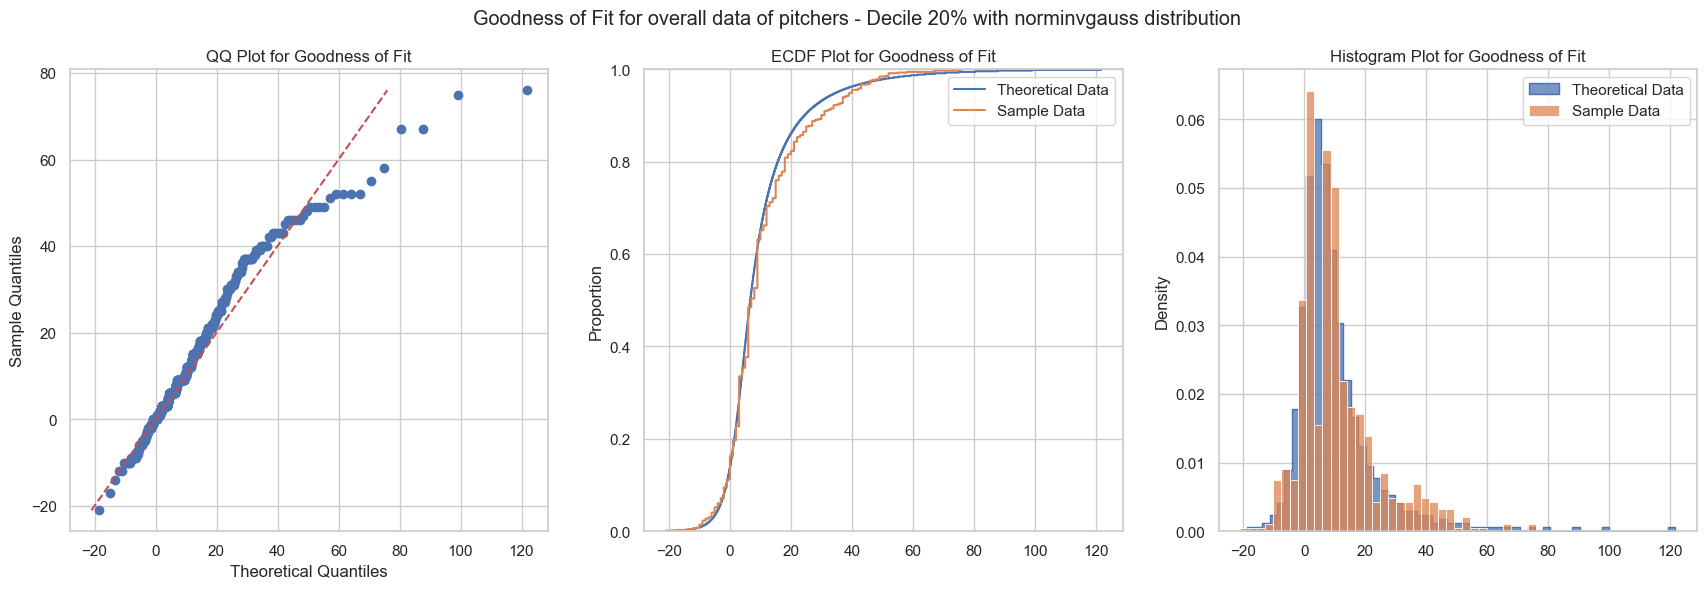

In [115]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(10, 20]'], 
    distribution_name="norminvgauss", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 20% with norminvgauss distribution"
)

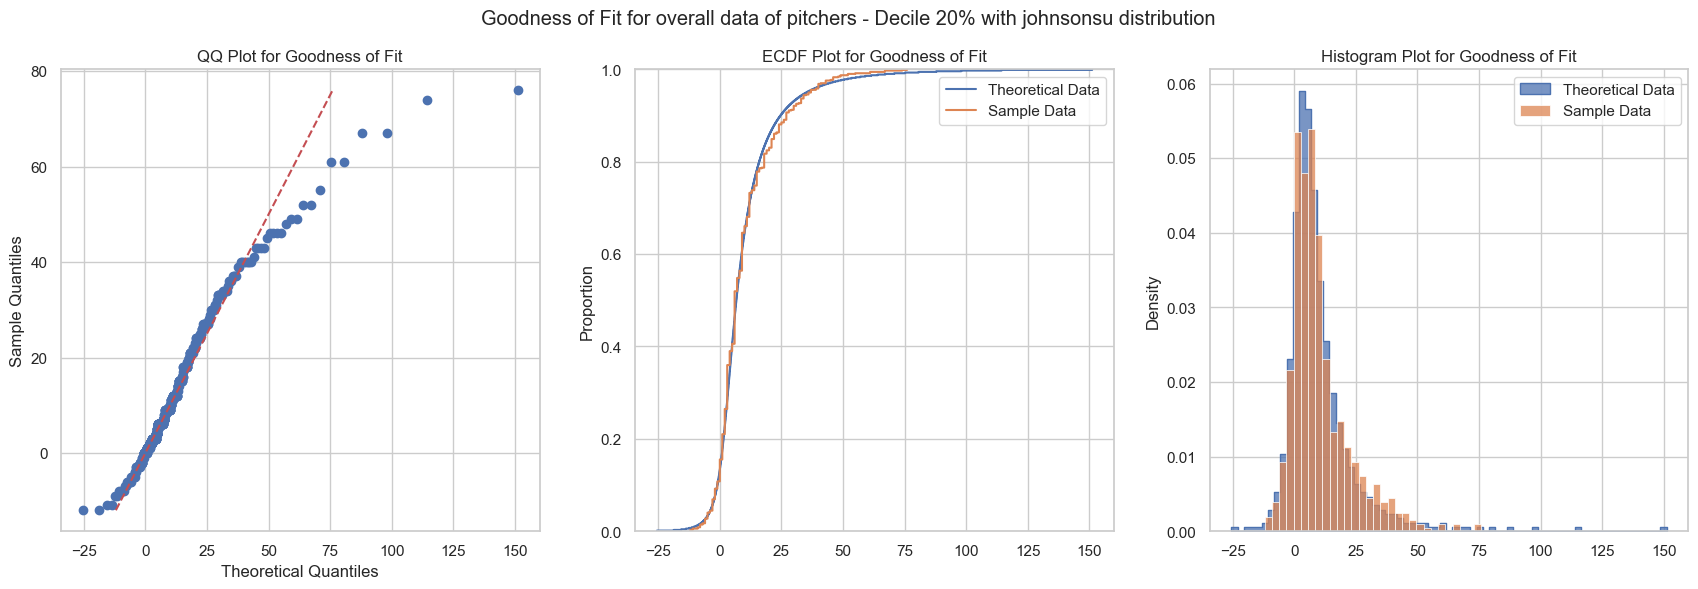

In [116]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(10, 20]'], 
    distribution_name="johnsonsu", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 20% with johnsonsu distribution"
)

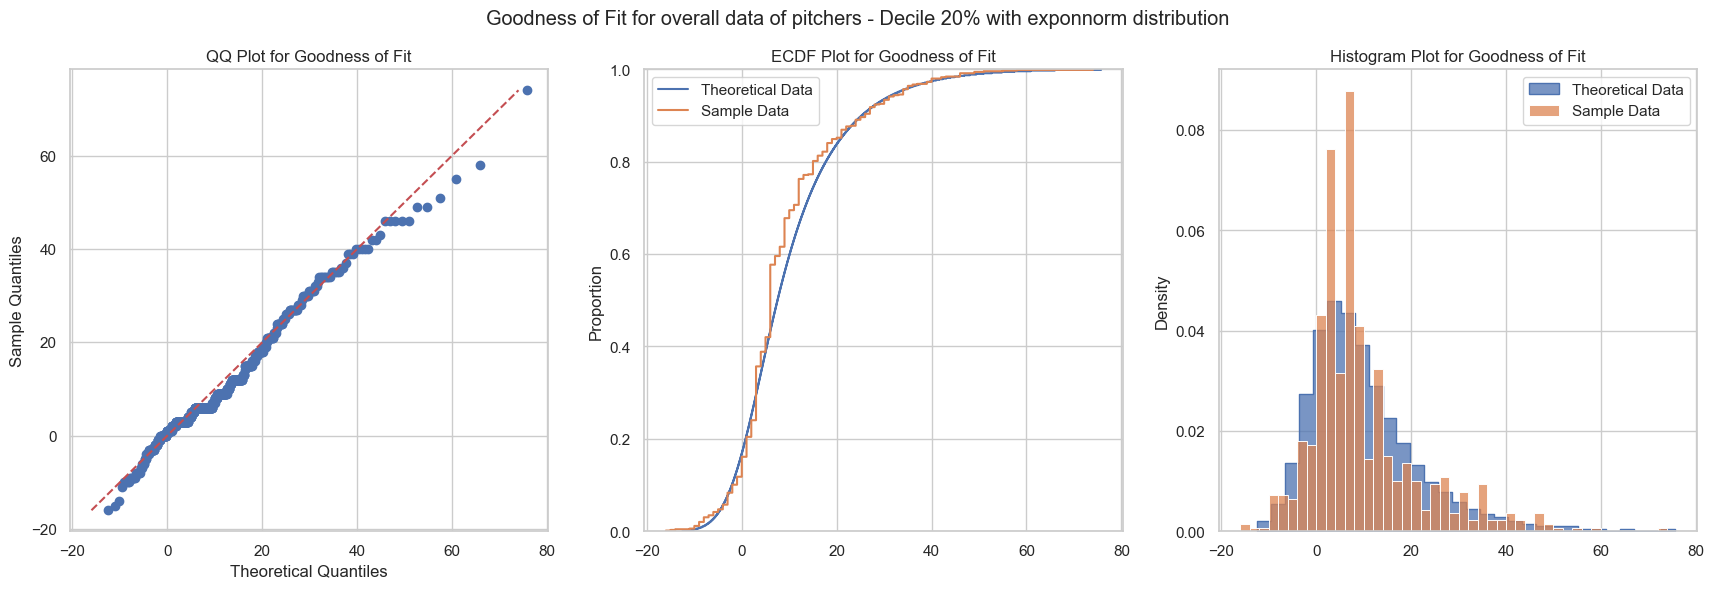

In [117]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(10, 20]'], 
    distribution_name="exponnorm", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 20% with exponnorm distribution"
)

##### **Decile 30%**

In [118]:
fitters['(20, 30]'].summary(sort_by="ks_statistic", top_n=10)

distribution  squared_error         aic          bic  \
norminvgauss    norminvgauss       0.017510  954.122589   981.511454   
johnsonsu          johnsonsu       0.017336  948.556896   975.945760   
exponnorm          exponnorm       0.018941  987.027445  1007.569094   
genhyperbolic  genhyperbolic       0.016714  942.020209   976.256289   

               kullberg_divergence  ks_statistic    ks_p_value  \
norminvgauss                   inf      0.073049  1.016166e-32   
johnsonsu                      inf      0.074552  4.600137e-34   
exponnorm                      inf      0.101743  3.933345e-63   
genhyperbolic                  inf      0.685510  0.000000e+00   

                                                   fitted_params  
norminvgauss   {'a': 0.9633246054741431, 'b': 0.7688279016018...  
johnsonsu      {'a': -1.018279604756335, 'b': 0.9969285068563...  
exponnorm      {'K': 2.809906684191549, 'loc': -0.65687126230...  
genhyperbolic  {'p': 0.7238108240688519, 'a': 2.3468999919311...

/opt/miniconda3/envs/statistical-simulation/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:3759: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intgrl = integrate.quad(llc, x0, x1,
/opt/miniconda3/envs/statistical-simulation/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:3754: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intgrl = (integrate.quad(llc, x0, mean,
/opt/miniconda3/envs/statistical-simulation/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:3756: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  + integrate.quad(llc, mean, x1,
/opt/miniconda3/envs/statistical-simulation/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:3756: IntegrationWarni

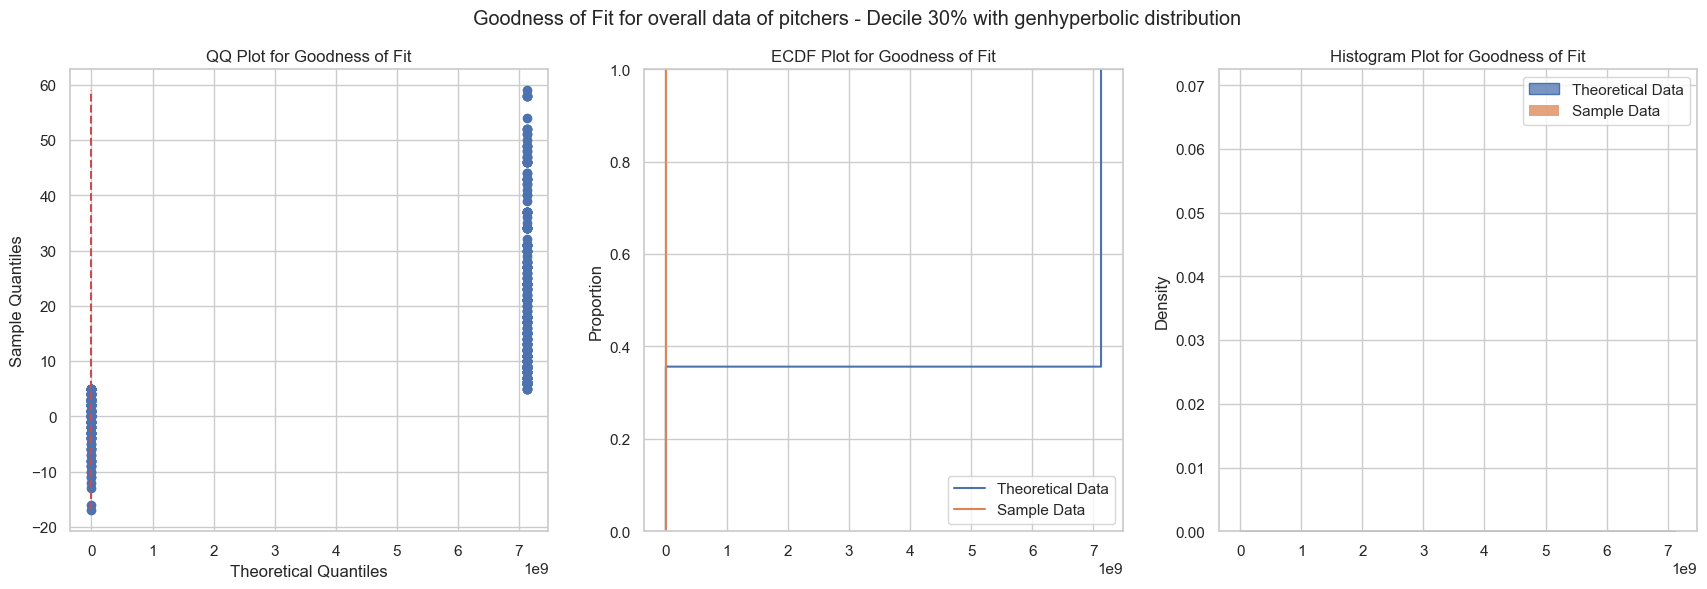

In [119]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(20, 30]'], 
    distribution_name="genhyperbolic", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 30% with genhyperbolic distribution"
)

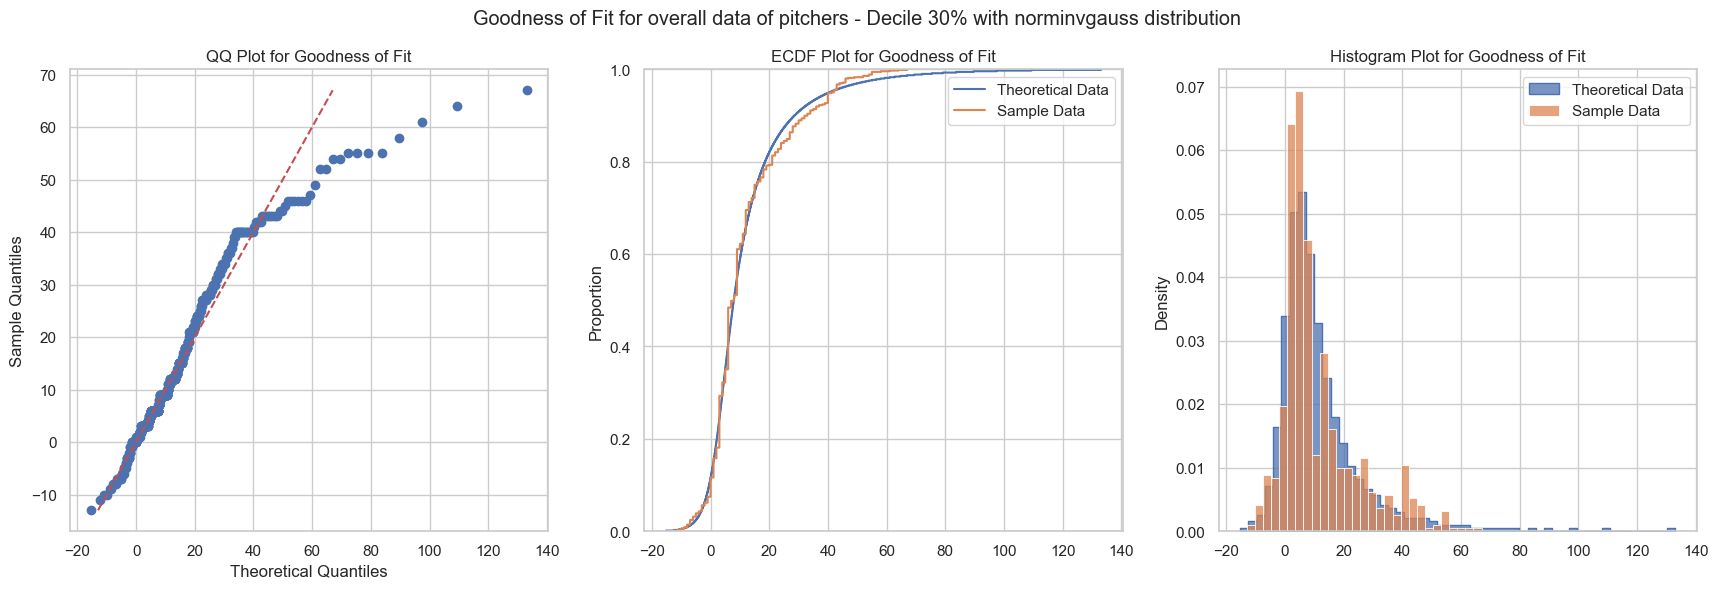

In [120]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(20, 30]'], 
    distribution_name="norminvgauss", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 30% with norminvgauss distribution"
)

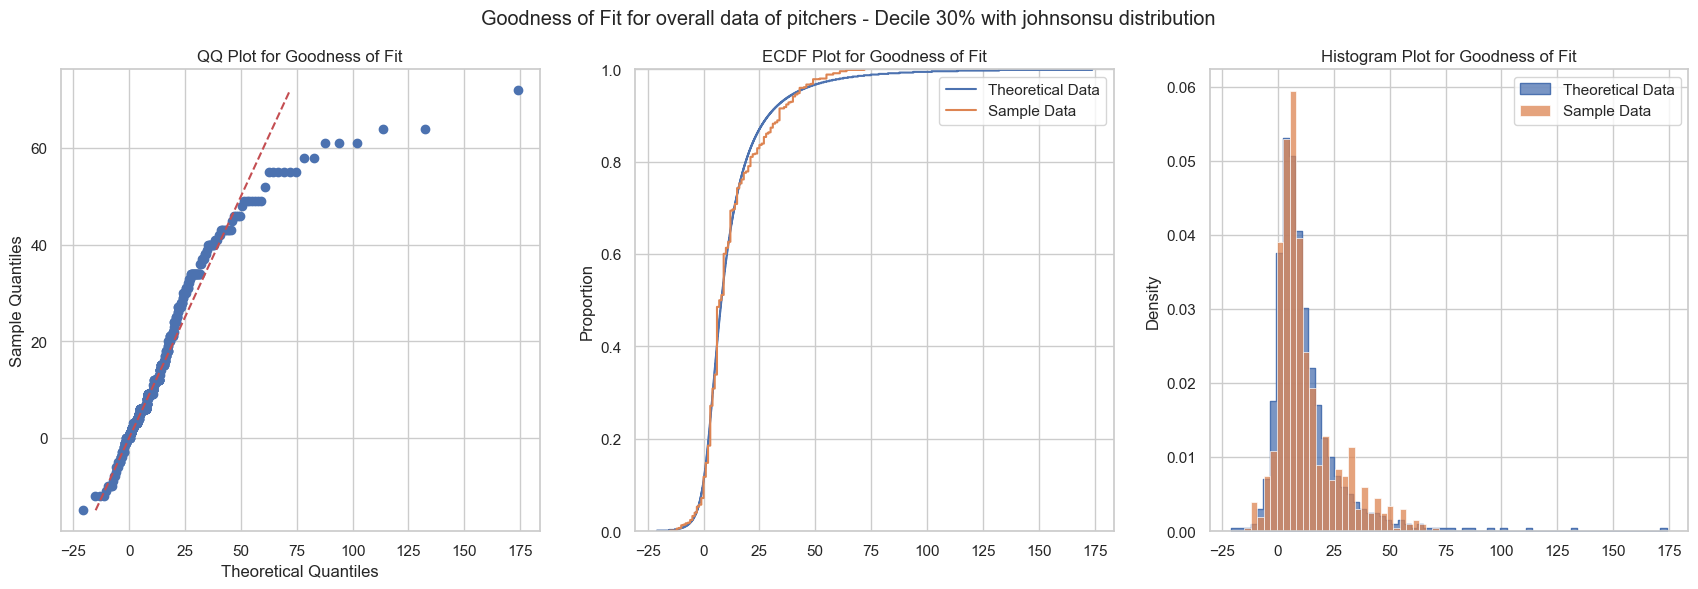

In [121]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(20, 30]'], 
    distribution_name="johnsonsu", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 30% with johnsonsu distribution"
)

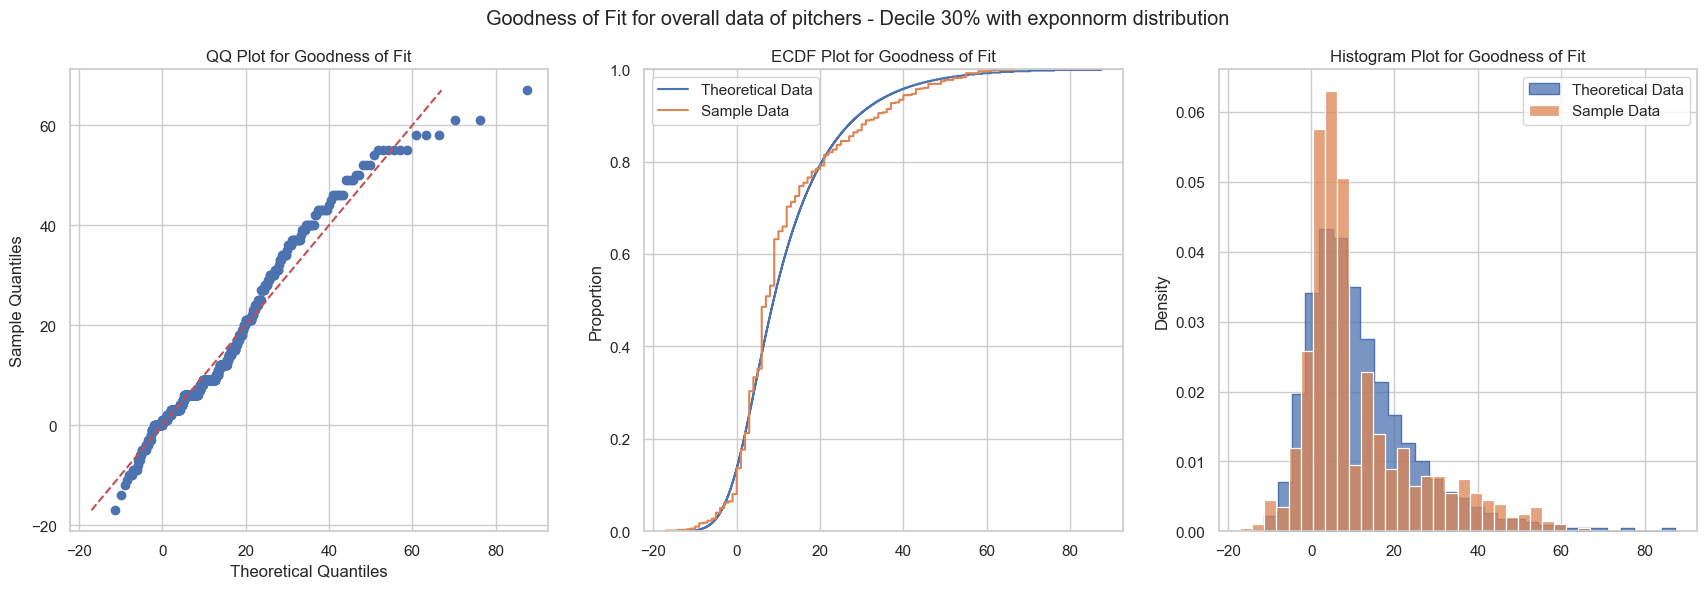

In [122]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(20, 30]'], 
    distribution_name="exponnorm", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 30% with exponnorm distribution"
)

##### **Decile 40%**

In [123]:
fitters['(30, 40]'].summary(sort_by="ks_statistic", top_n=10)

distribution  squared_error          aic          bic  \
norminvgauss    norminvgauss       0.010203  1001.215796  1028.611556   
johnsonsu          johnsonsu       0.010121   986.707544  1014.103304   
exponnorm          exponnorm       0.010962  1055.846383  1076.393203   
genhyperbolic  genhyperbolic       0.010187   983.453978  1017.698678   

               kullberg_divergence  ks_statistic    ks_p_value  \
norminvgauss                   inf      0.074640  3.352202e-34   
johnsonsu                      inf      0.075825  2.772241e-35   
exponnorm                      inf      0.098067  8.948606e-59   
genhyperbolic                  inf      0.662612  0.000000e+00   

                                                   fitted_params  
norminvgauss   {'a': 1.2346512048566067, 'b': 1.0200417412547...  
johnsonsu      {'a': -1.1679579160831244, 'b': 1.023180529246...  
exponnorm      {'K': 3.0787882951520515, 'loc': -0.7368054123...  
genhyperbolic  {'p': 0.8388297716164776, 'a': 7.3299107278989...

/opt/miniconda3/envs/statistical-simulation/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:3759: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intgrl = integrate.quad(llc, x0, x1,
/opt/miniconda3/envs/statistical-simulation/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:3754: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intgrl = (integrate.quad(llc, x0, mean,
/opt/miniconda3/envs/statistical-simulation/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:3756: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  + integrate.quad(llc, mean, x1,
/opt/miniconda3/envs/statistical-simulation/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:3756: IntegrationWarni

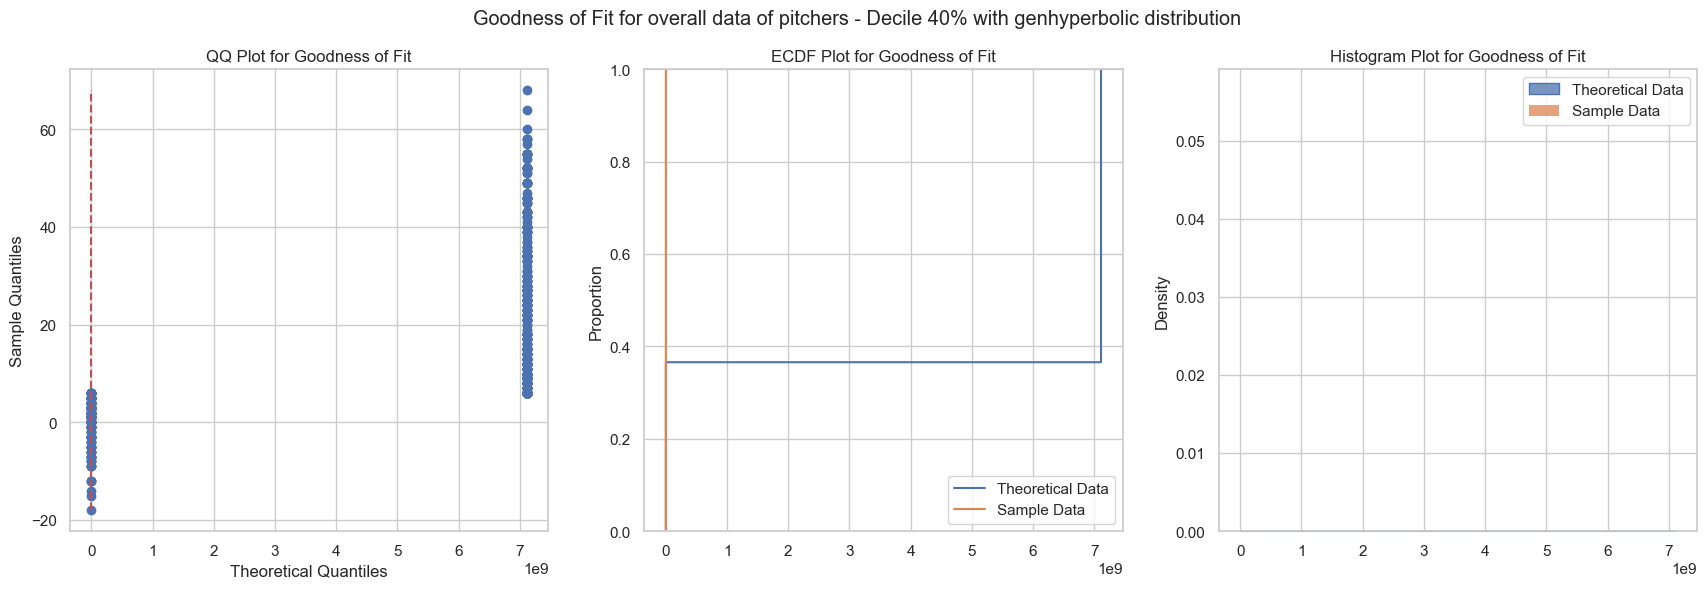

In [124]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(30, 40]'], 
    distribution_name="genhyperbolic", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 40% with genhyperbolic distribution"
)

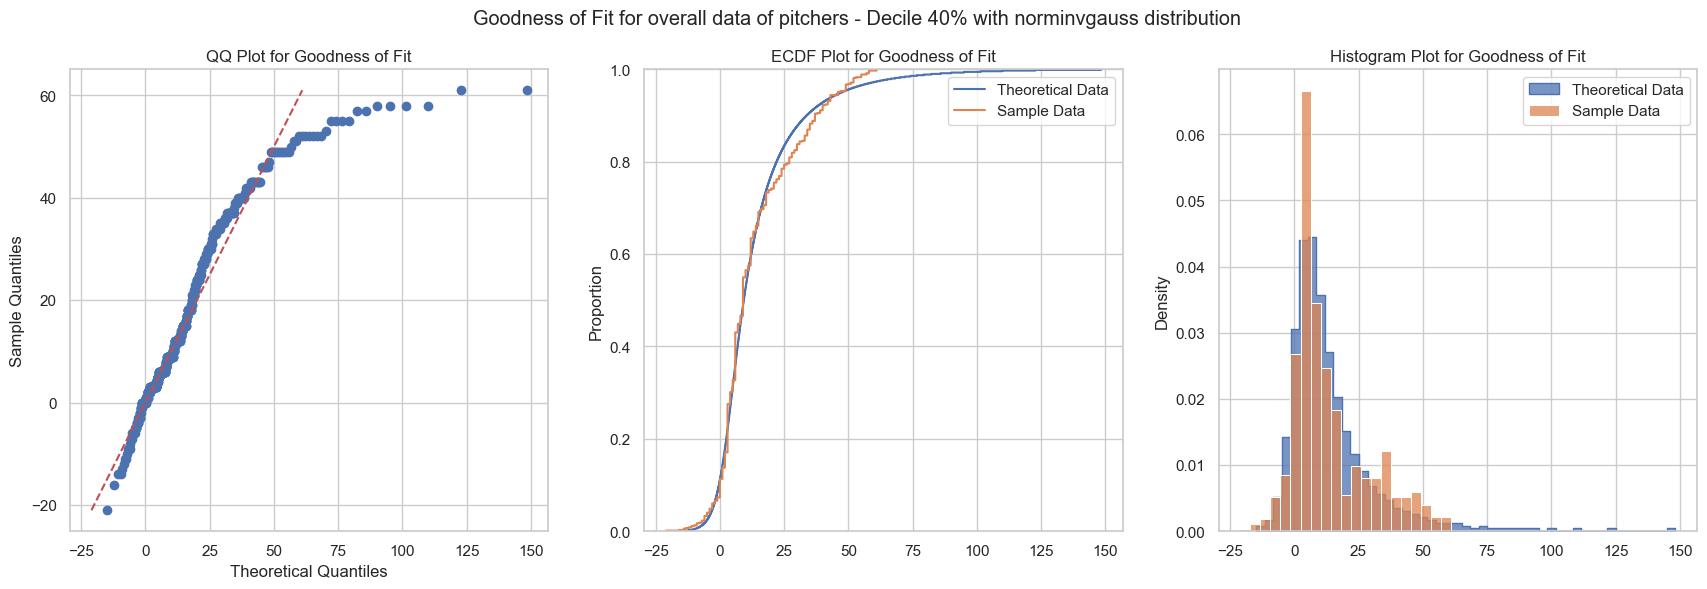

In [125]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(30, 40]'], 
    distribution_name="norminvgauss", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 40% with norminvgauss distribution"
)

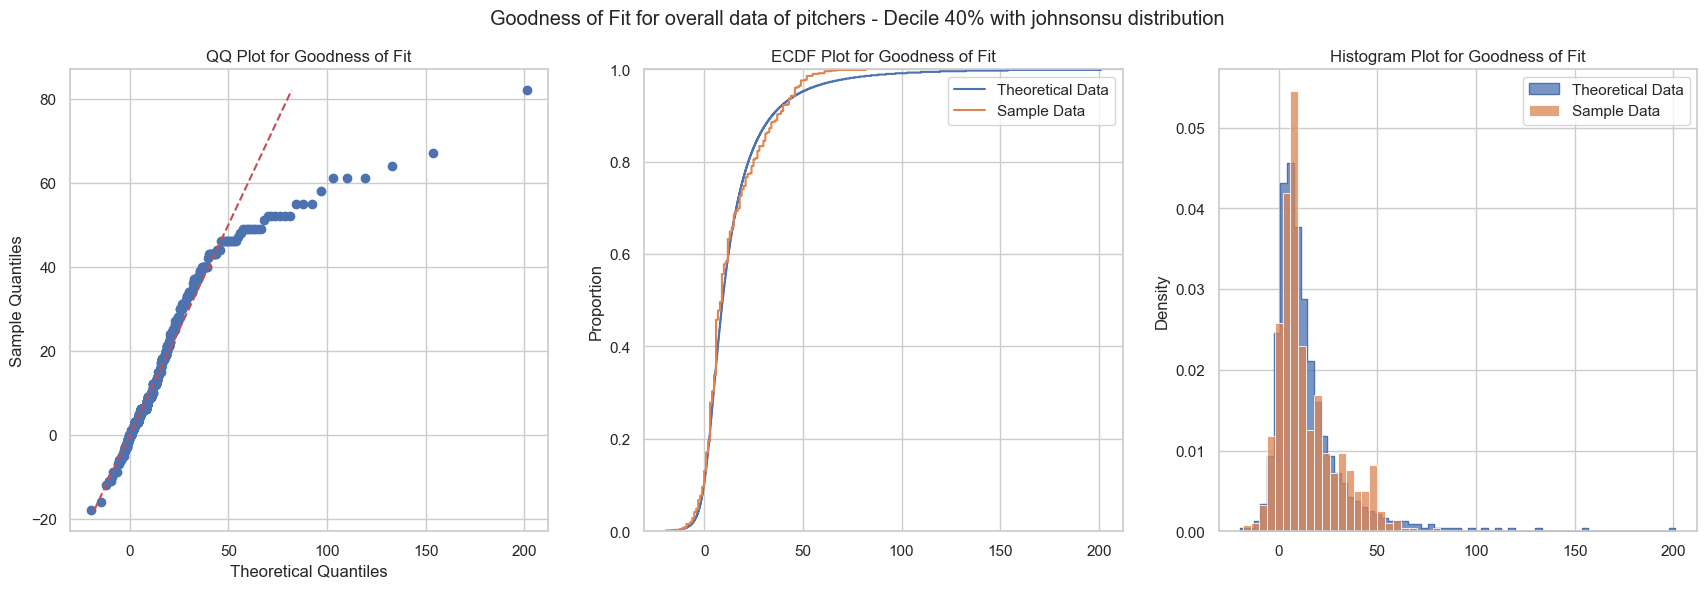

In [126]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(30, 40]'], 
    distribution_name="johnsonsu", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 40% with johnsonsu distribution"
)

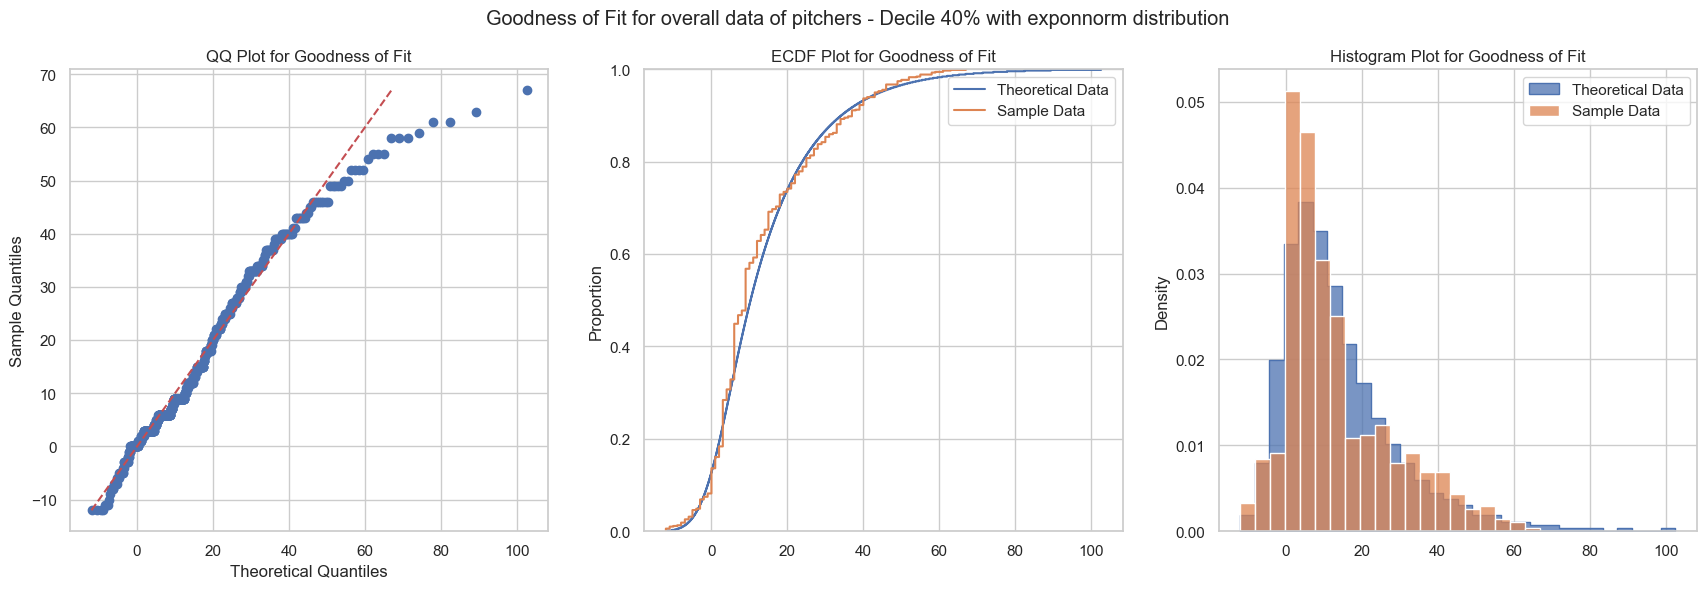

In [127]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(30, 40]'], 
    distribution_name="exponnorm", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 40% with exponnorm distribution"
)

##### **Decile 50%**

In [128]:
fitters['(40, 50]'].summary(sort_by="ks_statistic", top_n=10)

distribution  squared_error         aic         bic  \
norminvgauss    norminvgauss       0.007662  951.607836  978.999575   
johnsonsu          johnsonsu       0.007541  946.768496  974.160235   
exponnorm          exponnorm       0.008510  963.102947  983.646751   
genhyperbolic  genhyperbolic       0.006711  938.006167  972.245841   

               kullberg_divergence  ks_statistic    ks_p_value  \
norminvgauss                   inf      0.076644  5.265376e-36   
johnsonsu                      inf      0.077757  4.778994e-37   
exponnorm                      inf      0.096195  1.652899e-56   
genhyperbolic                  inf      0.661724  0.000000e+00   

                                                   fitted_params  
norminvgauss   {'a': 1.3963032163736968, 'b': 1.1886867898100...  
johnsonsu      {'a': -1.2466625822168211, 'b': 1.016559823294...  
exponnorm      {'K': 3.4948012405738043, 'loc': -1.0884620203...  
genhyperbolic  {'p': 0.7746803634984608, 'a': 3.1845038160273...

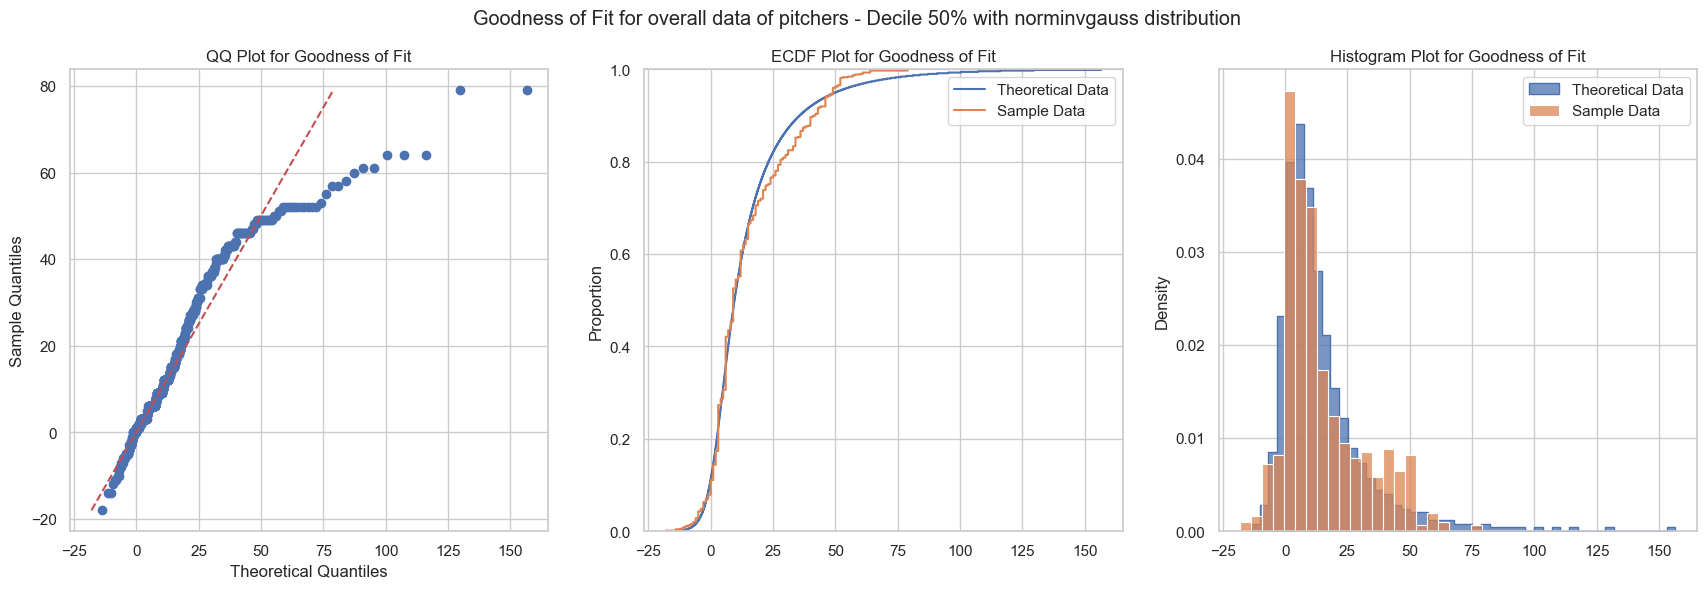

In [129]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(40, 50]'], 
    distribution_name="norminvgauss", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 50% with norminvgauss distribution"
)

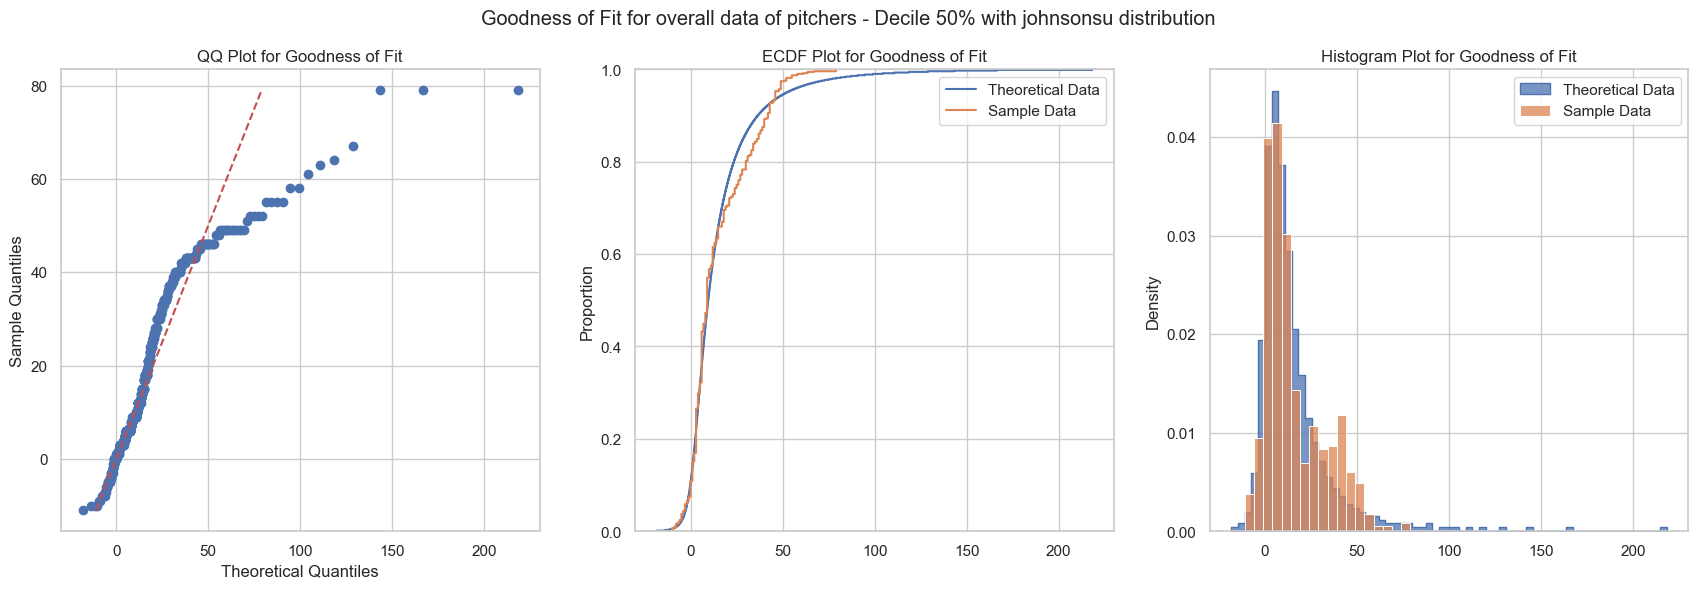

In [130]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(40, 50]'], 
    distribution_name="johnsonsu", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 50% with johnsonsu distribution"
)

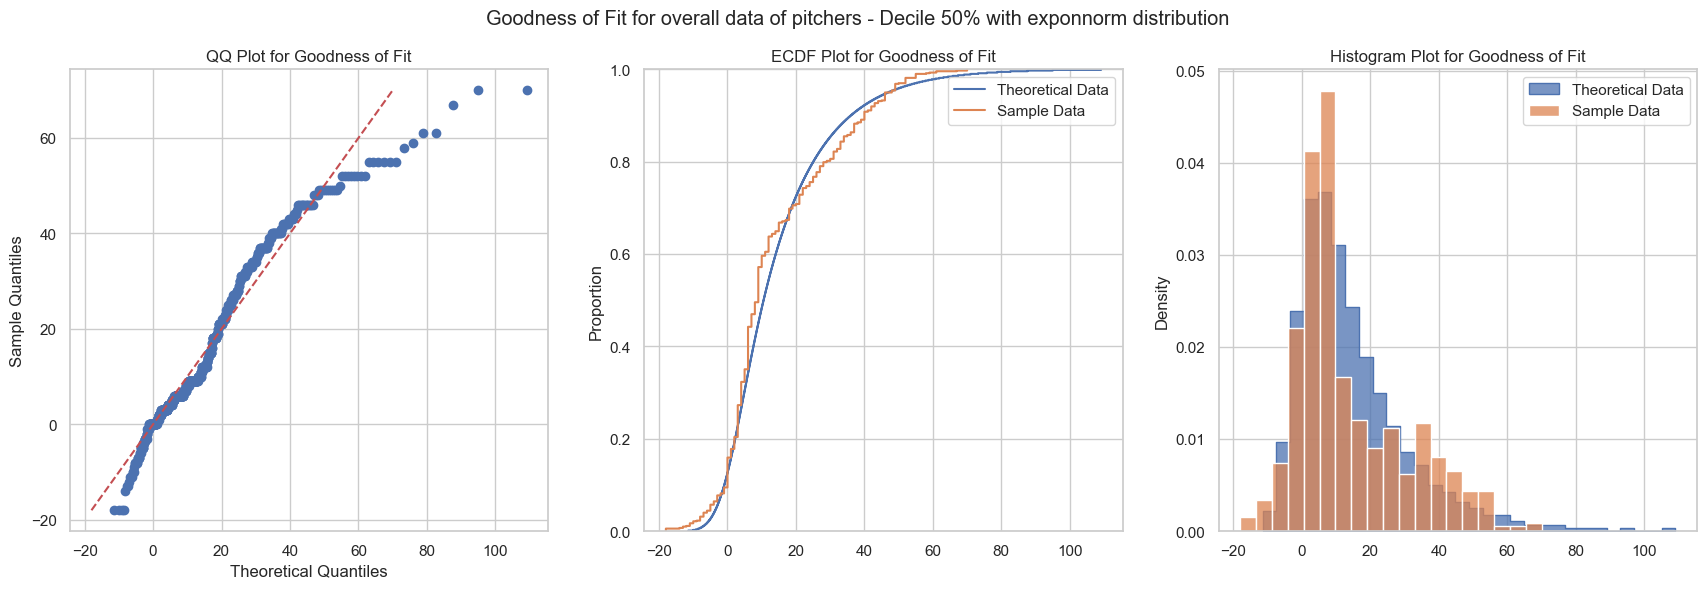

In [131]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(40, 50]'], 
    distribution_name="exponnorm", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 50% with exponnorm distribution"
)

##### **Decile 60%**

In [132]:
fitters['(50, 60]'].summary(sort_by="ks_statistic", top_n=10)

distribution  squared_error         aic         bic  \
norminvgauss    norminvgauss       0.009975  936.589808  963.997606   
johnsonsu          johnsonsu       0.009938  932.541584  959.949383   
exponnorm          exponnorm       0.011338  941.311872  961.867721   
genhyperbolic  genhyperbolic       0.009595  921.923239  956.182987   

               kullberg_divergence  ks_statistic    ks_p_value  \
norminvgauss                   inf      0.071302  2.444983e-31   
johnsonsu                      inf      0.074912  1.498133e-34   
exponnorm                      inf      0.111769  1.715845e-76   
genhyperbolic                  inf      0.675455  0.000000e+00   

                                                   fitted_params  
norminvgauss   {'a': 1.2187100568442903, 'b': 1.0483965213178...  
johnsonsu      {'a': -1.1974731780314936, 'b': 0.971371375405...  
exponnorm      {'K': 3.590286445683425, 'loc': -1.19296190023...  
genhyperbolic  {'p': 0.8438327118615259, 'a': 7.3064849493534...

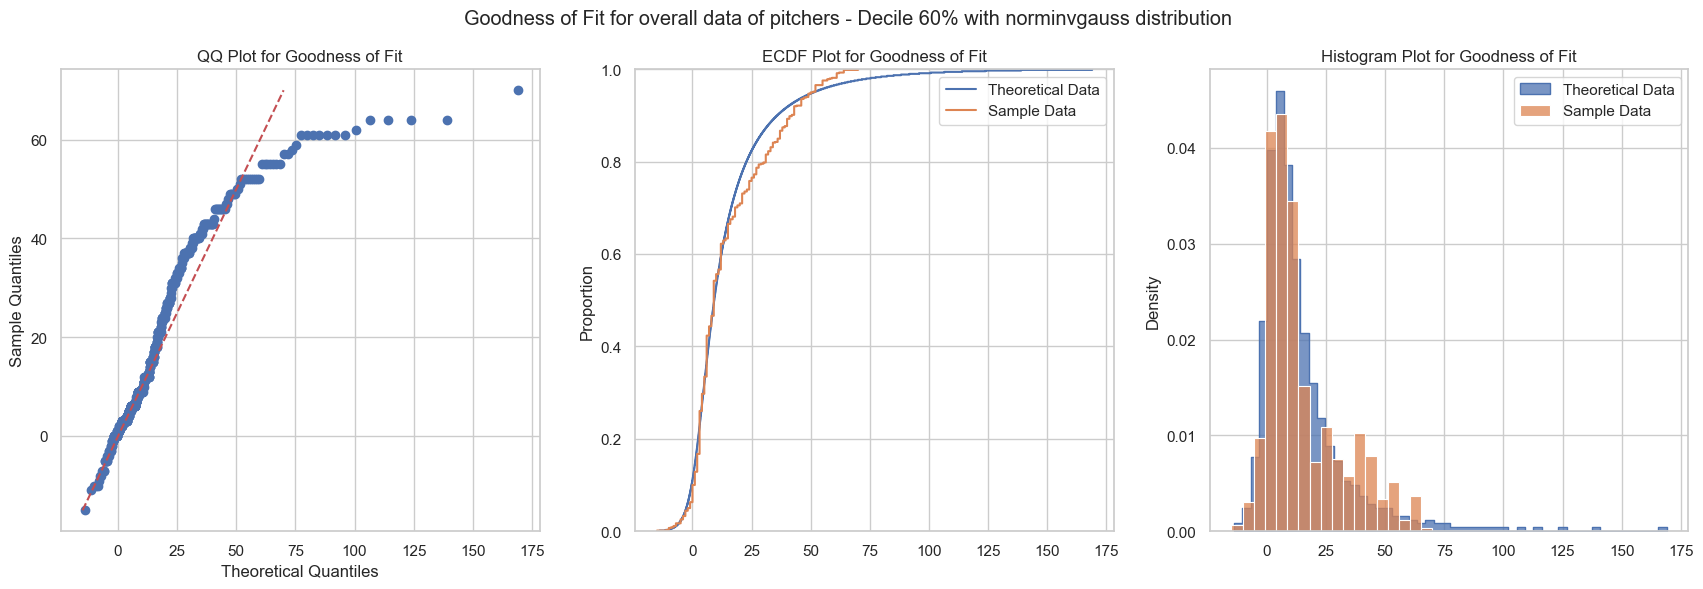

In [133]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(50, 60]'], 
    distribution_name="norminvgauss", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 60% with norminvgauss distribution"
)

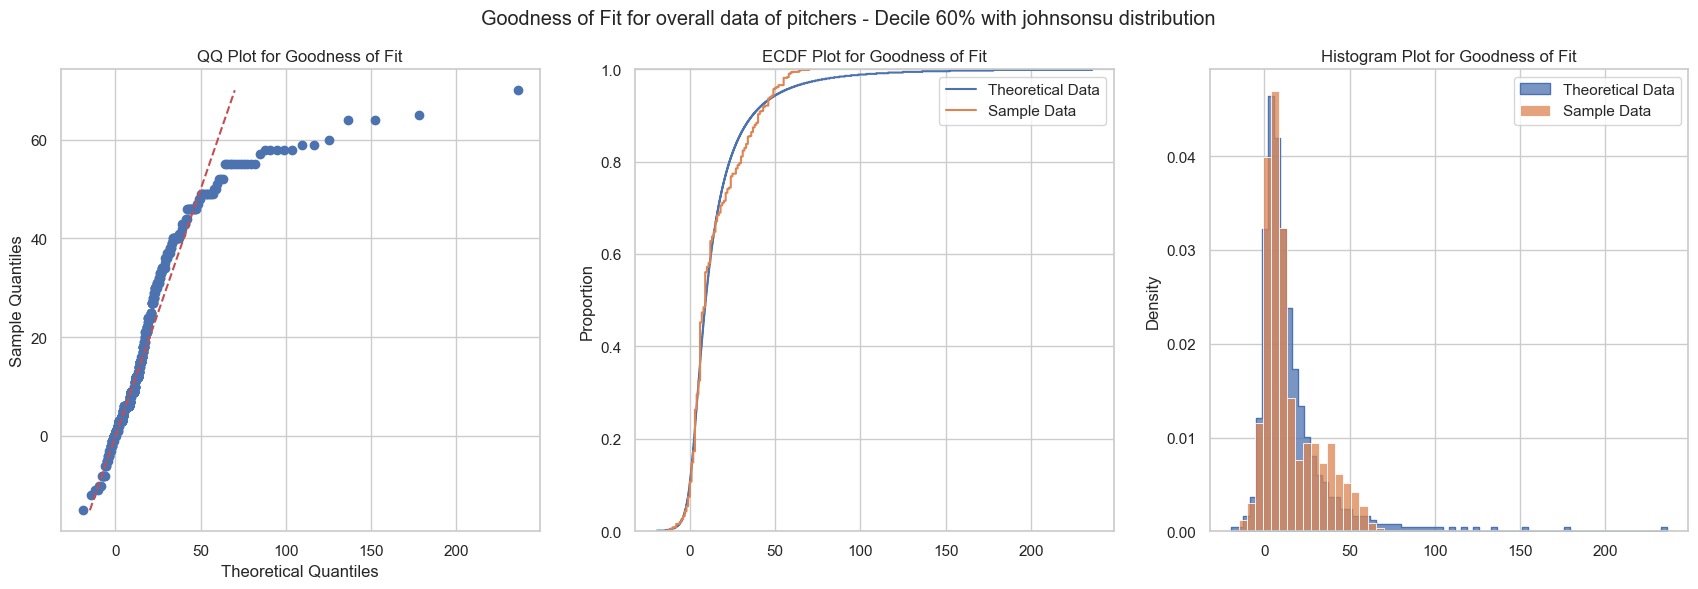

In [134]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(50, 60]'], 
    distribution_name="johnsonsu", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 60% with johnsonsu distribution"
)

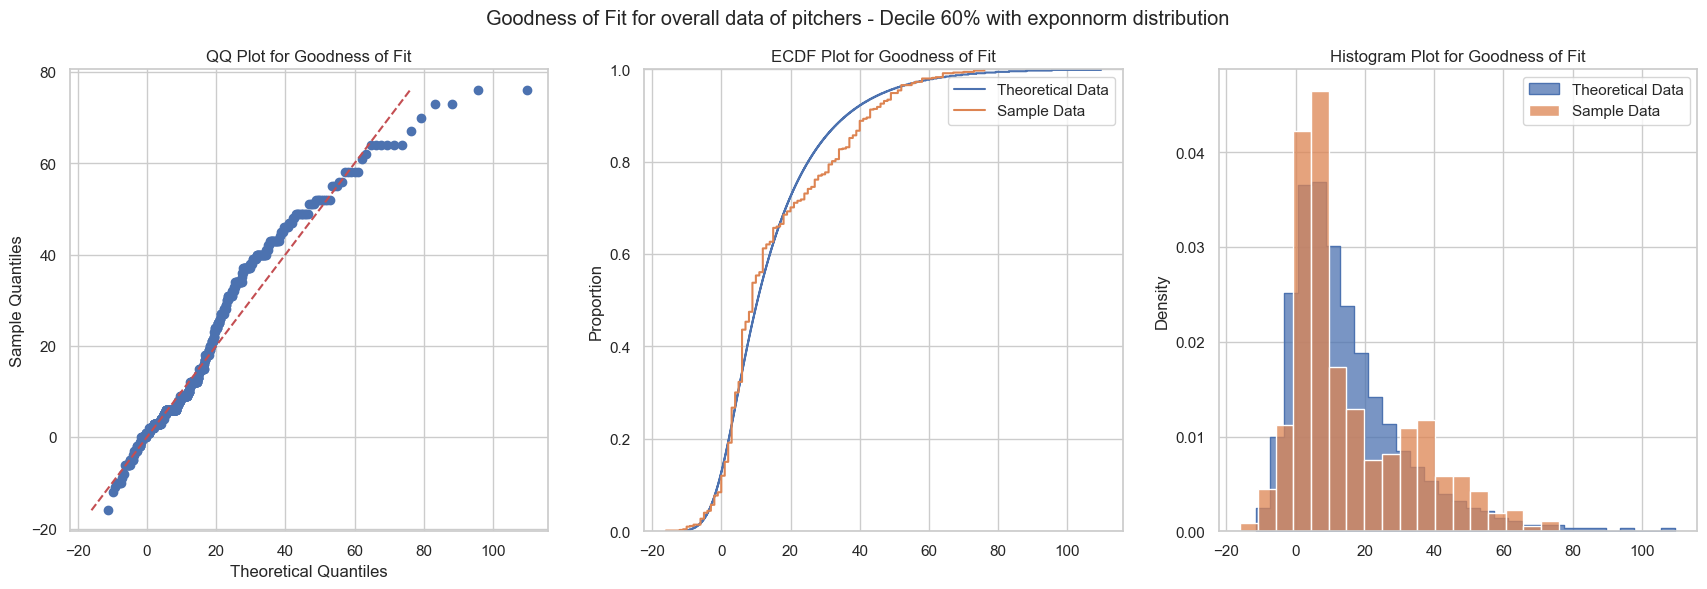

In [135]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(50, 60]'], 
    distribution_name="exponnorm", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 60% with exponnorm distribution"
)

##### **Decile 70%**

In [136]:
fitters['(60, 70]'].summary(sort_by="ks_statistic", top_n=10)

distribution  squared_error          aic          bic  \
johnsonsu          johnsonsu       0.027708  1001.940193  1029.305408   
norminvgauss    norminvgauss       0.027157  1004.386762  1031.751977   
genhyperbolic  genhyperbolic       0.027083  1000.295694  1034.502212   
exponnorm          exponnorm       0.032952  1127.111490  1147.635401   

               kullberg_divergence  ks_statistic     ks_p_value  \
johnsonsu                      inf      0.087546   1.483240e-46   
norminvgauss                   inf      0.087861   6.890154e-47   
genhyperbolic                  inf      0.088502   1.434611e-47   
exponnorm                      inf      0.144181  6.883986e-126   

                                                   fitted_params  
johnsonsu      {'a': -0.6928363306075861, 'b': 0.854761246465...  
norminvgauss   {'a': 0.4219307885986133, 'b': 0.3236217459865...  
genhyperbolic  {'p': -0.32733696563070724, 'a': 0.38155209372...  
exponnorm      {'K': 2.4343485904653686, 'loc': -0.3131618424...

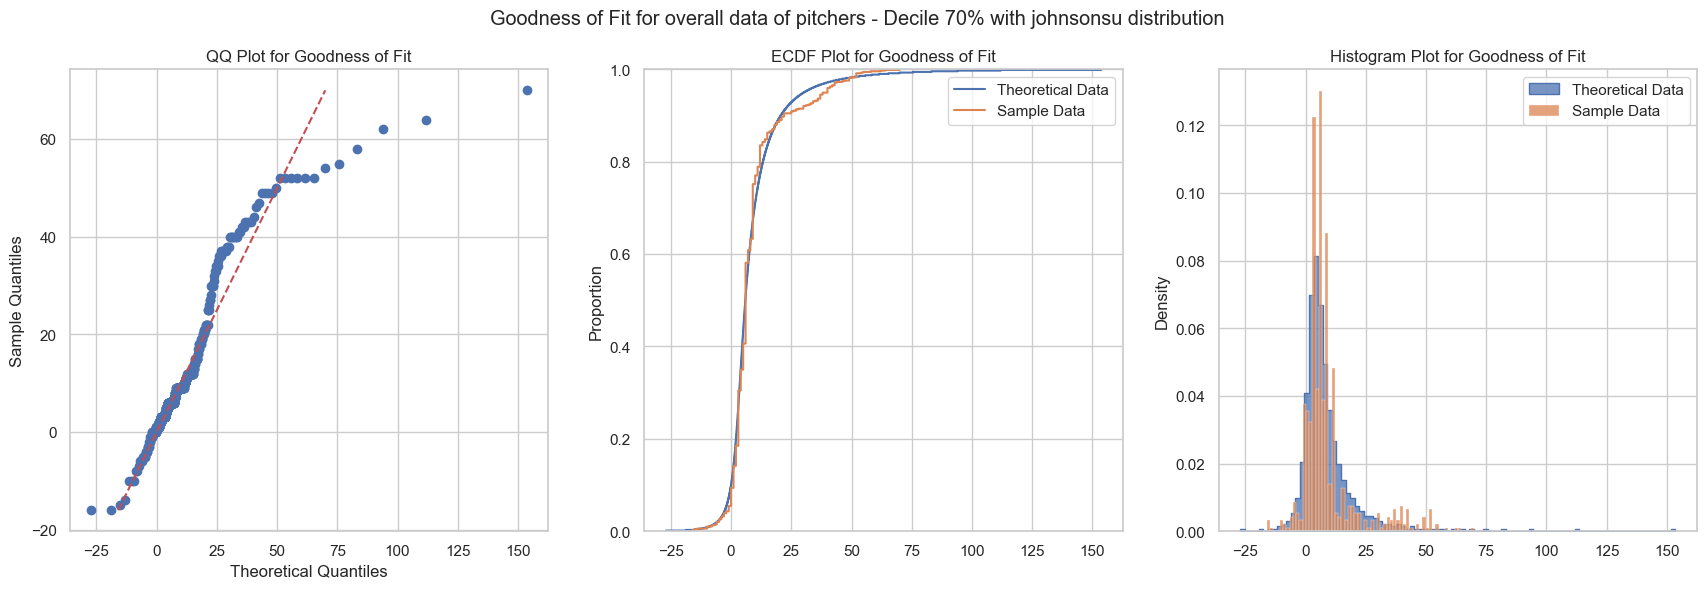

In [137]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(60, 70]'], 
    distribution_name="johnsonsu", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 70% with johnsonsu distribution"
)

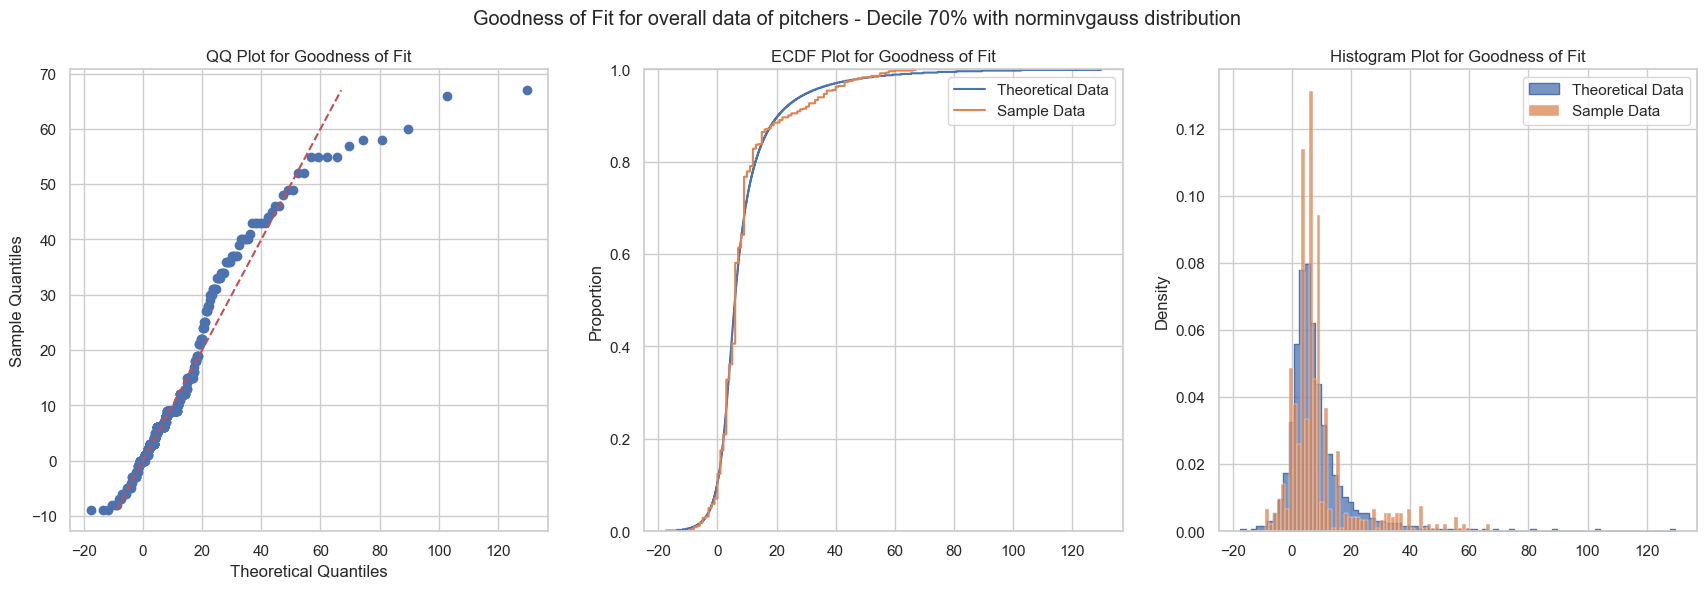

In [138]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(60, 70]'], 
    distribution_name="norminvgauss", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 70% with norminvgauss distribution"
)

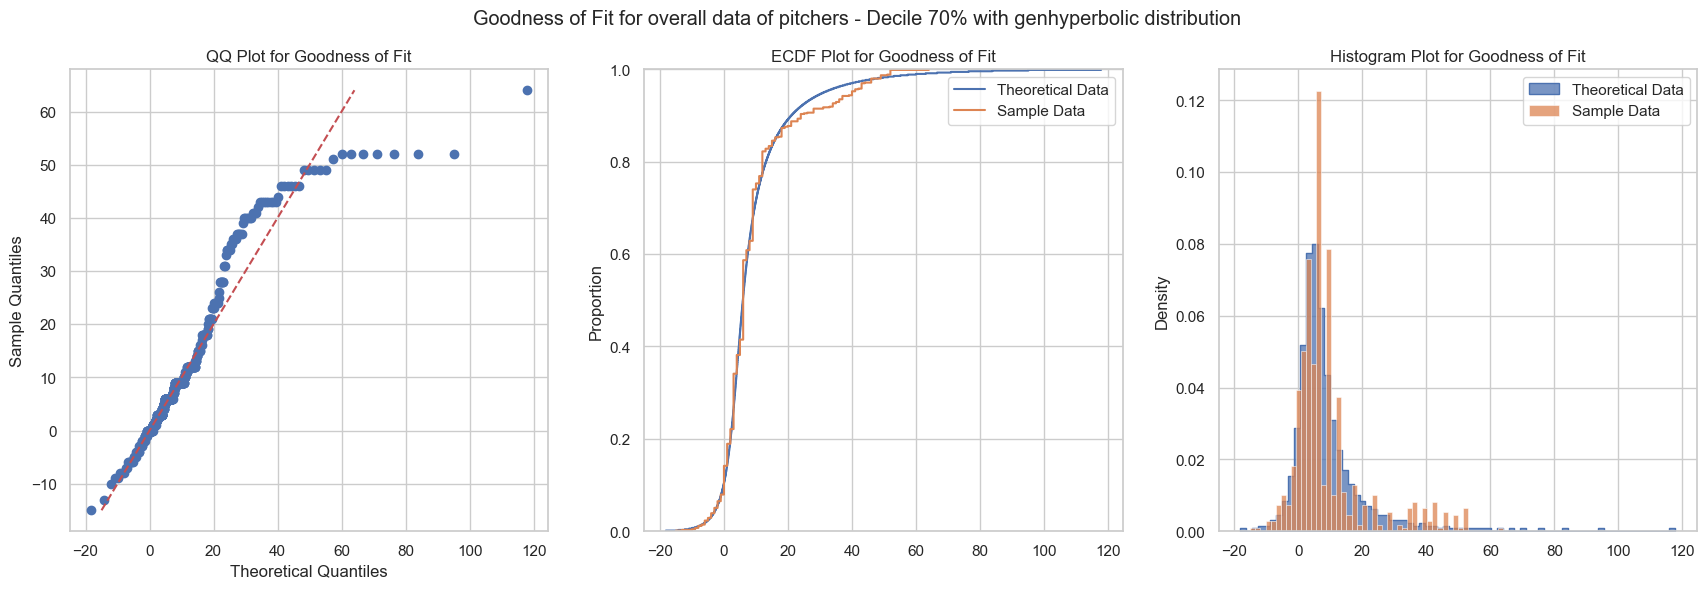

In [139]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(60, 70]'], 
    distribution_name="genhyperbolic", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 70% with genhyperbolic distribution"
)

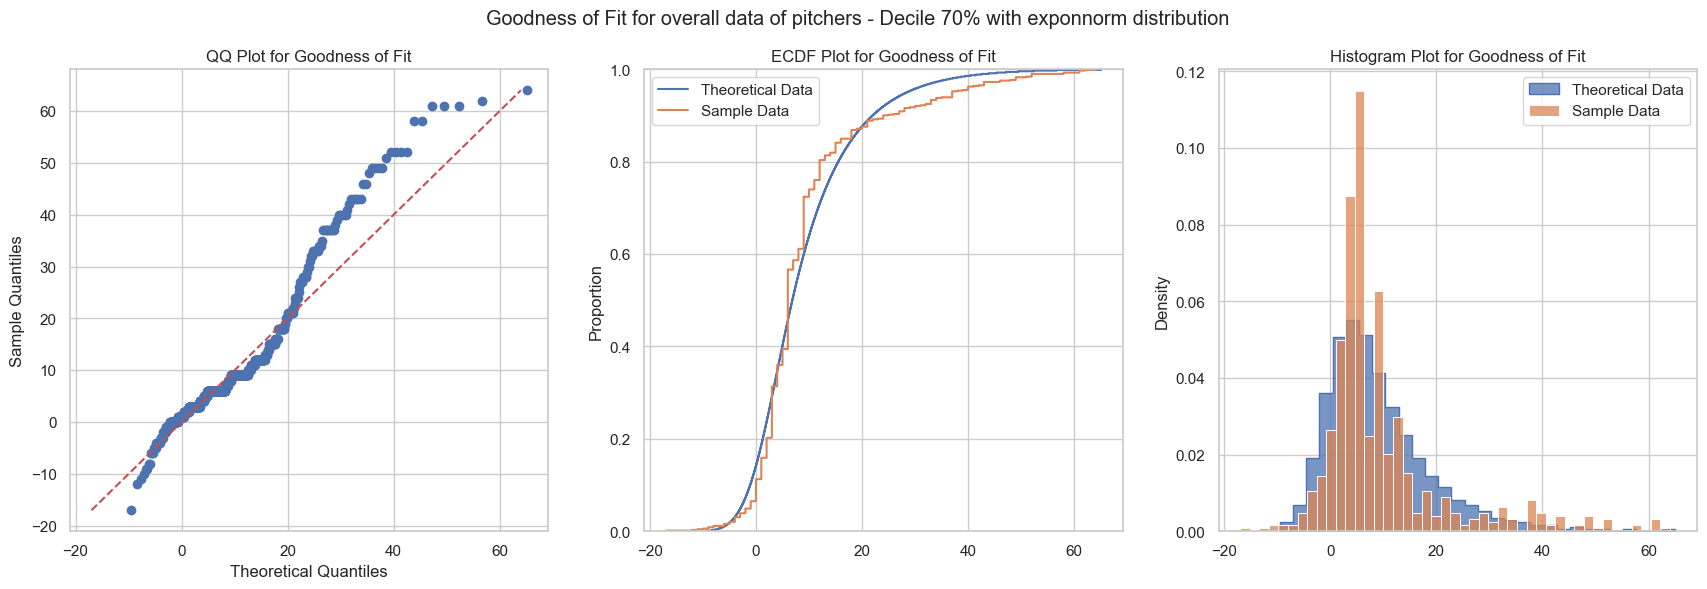

In [140]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(60, 70]'], 
    distribution_name="exponnorm", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 70% with exponnorm distribution"
)

##### **Decile 80%**

In [141]:
fitters['(70, 80]'].summary(sort_by="ks_statistic", top_n=10)

distribution  squared_error          aic          bic  \
johnsonsu          johnsonsu       0.072828  1065.320080  1092.707219   
genhyperbolic  genhyperbolic       0.072850  1067.398876  1101.632800   
norminvgauss    norminvgauss       0.072929  1071.679969  1099.067107   
exponnorm          exponnorm       0.074204  1241.711719  1262.252073   

               kullberg_divergence  ks_statistic    ks_p_value  \
johnsonsu                      inf      0.106841  1.469998e-69   
genhyperbolic                  inf      0.106876  1.326437e-69   
norminvgauss                   inf      0.107654  1.286837e-70   
exponnorm                      inf      0.113376  2.684793e-78   

                                                   fitted_params  
johnsonsu      {'a': -0.2401215155241579, 'b': 1.295350140028...  
genhyperbolic  {'p': -0.8322769505194187, 'a': 0.734000235165...  
norminvgauss   {'a': 0.7724474454423902, 'b': 0.1548985987753...  
exponnorm      {'K': 0.8454897009640197, 'loc': 2.04441059826...

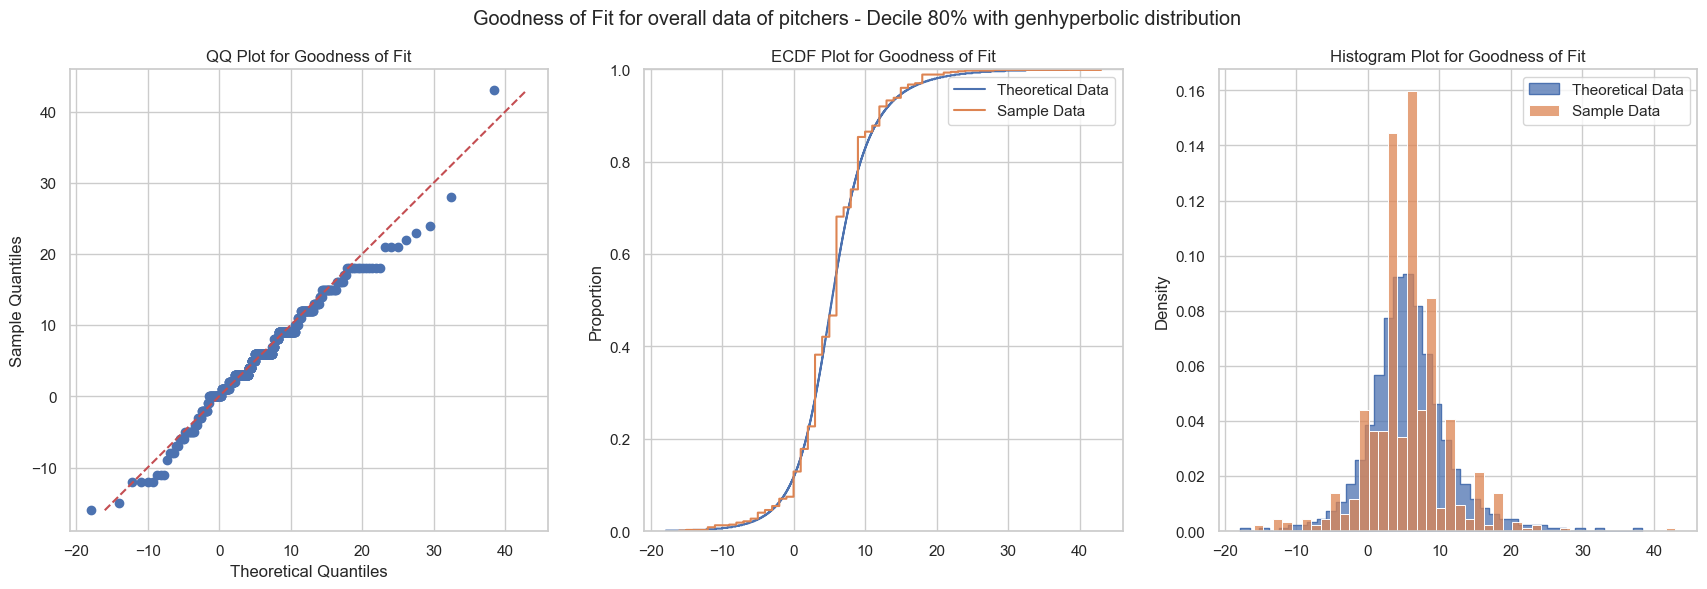

In [142]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(70, 80]'], 
    distribution_name="genhyperbolic", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 80% with genhyperbolic distribution"
)

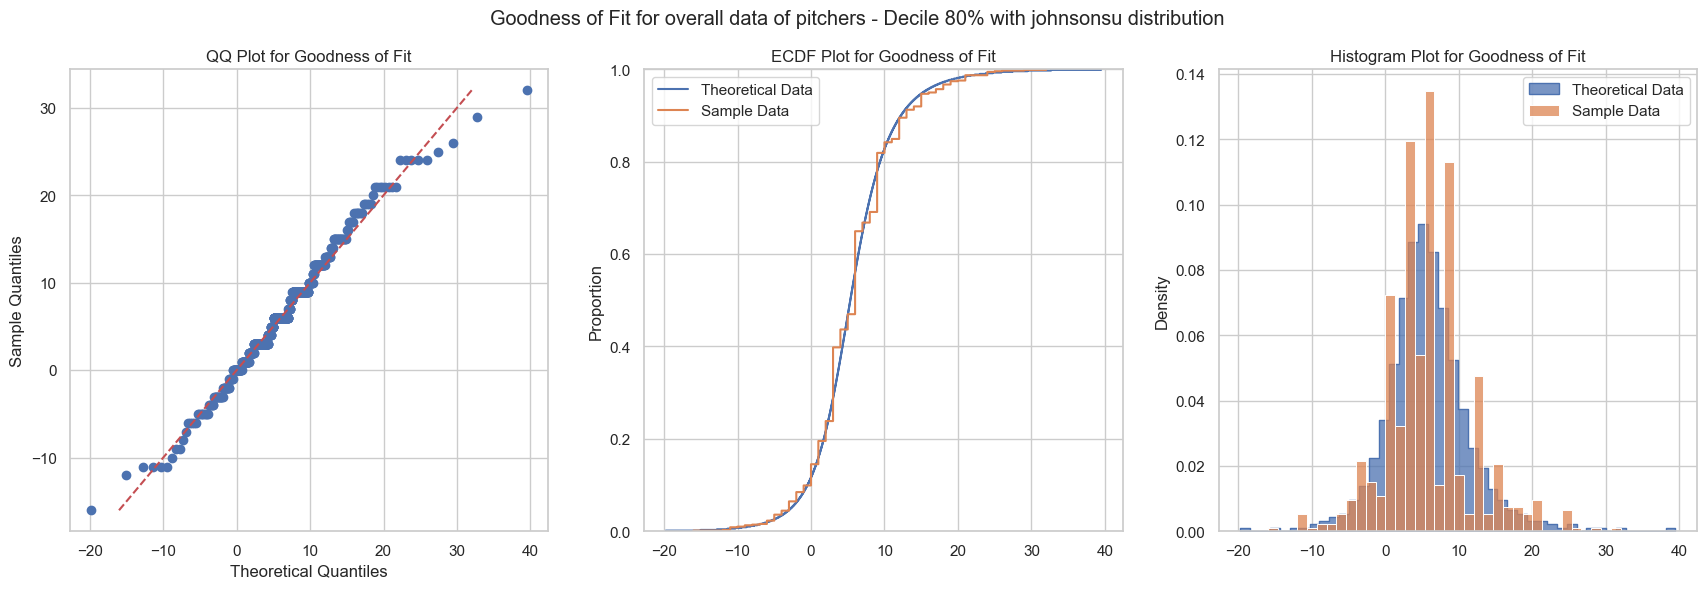

In [143]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(70, 80]'], 
    distribution_name="johnsonsu", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 80% with johnsonsu distribution"
)

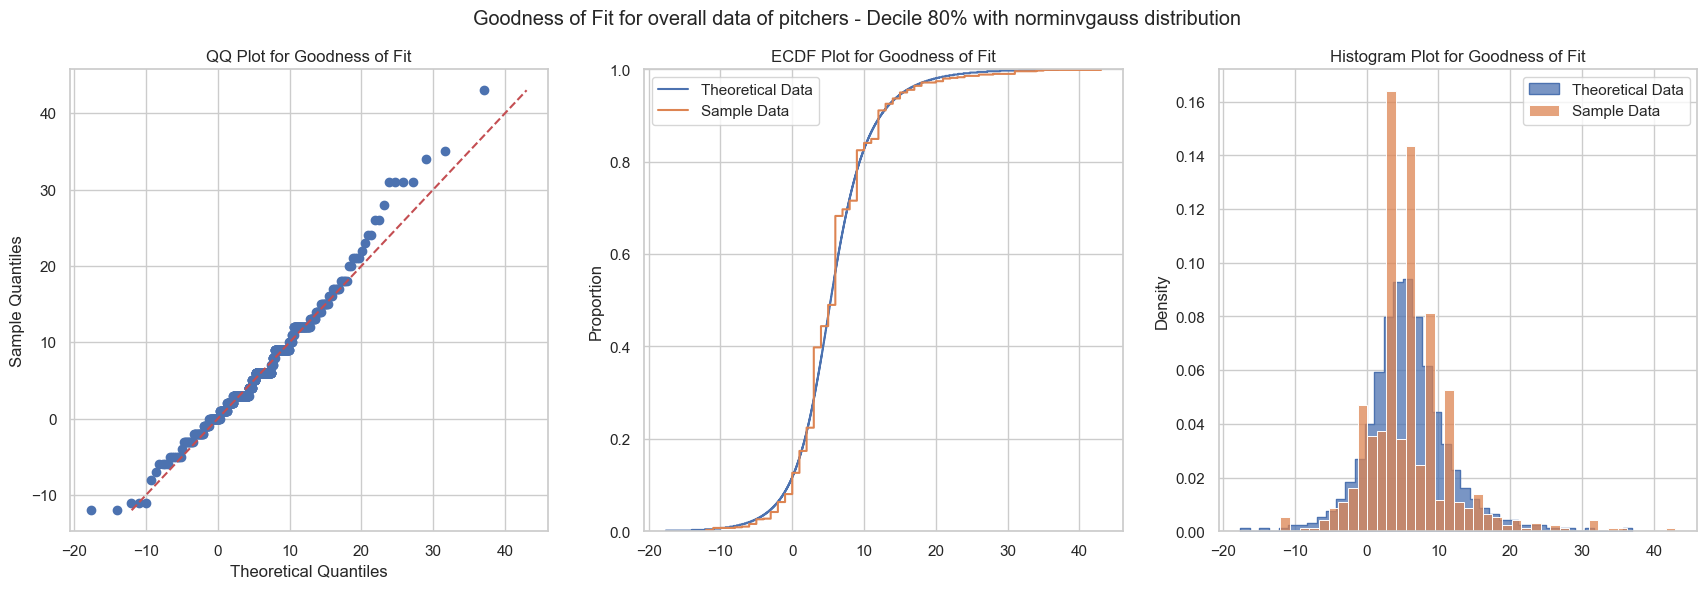

In [144]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(70, 80]'], 
    distribution_name="norminvgauss", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 80% with norminvgauss distribution"
)

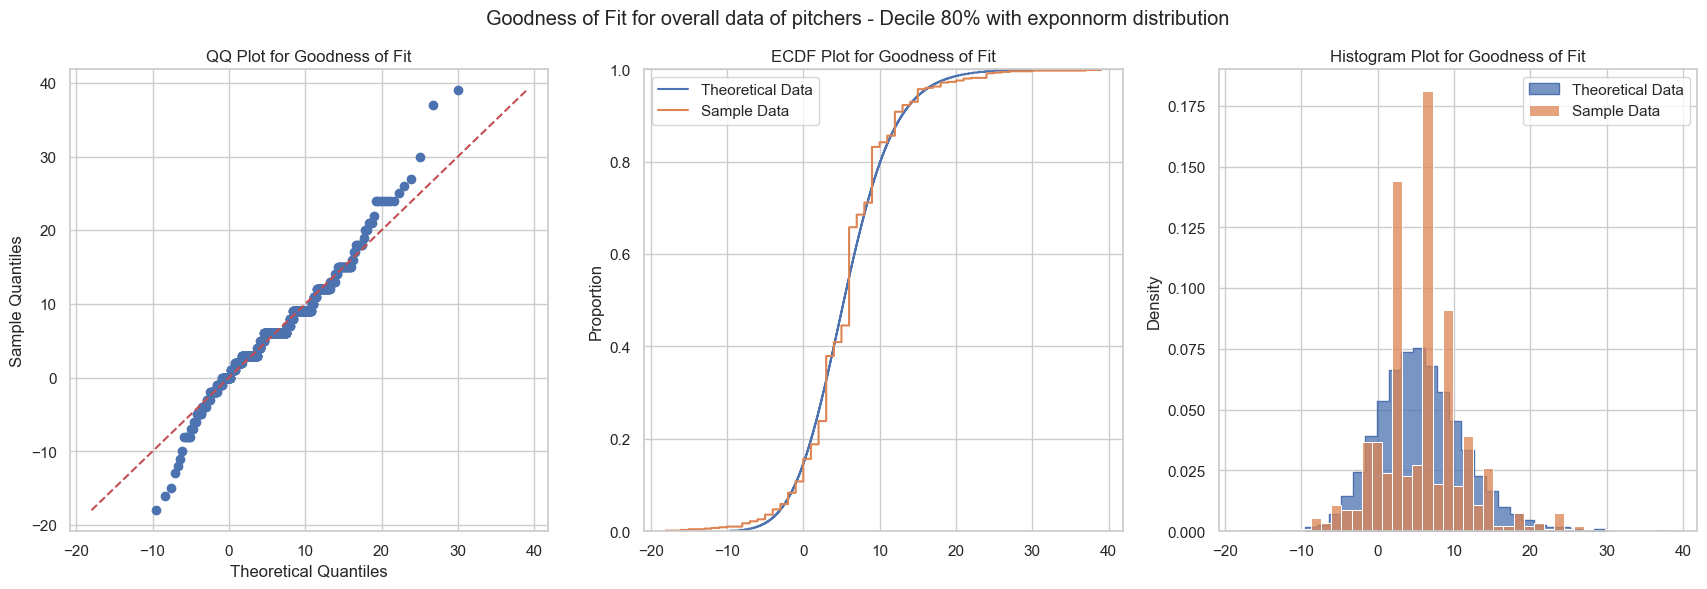

In [145]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(70, 80]'], 
    distribution_name="exponnorm", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 80% with exponnorm distribution"
)

##### **Decile 90%**

In [146]:
fitters['(80, 90]'].summary(sort_by="ks_statistic", top_n=10)

distribution  squared_error          aic          bic  \
norminvgauss    norminvgauss       0.093318  1169.536930  1196.919463   
johnsonsu          johnsonsu       0.093244  1147.167229  1174.549762   
exponnorm          exponnorm       0.094003  1392.951554  1413.488453   
genhyperbolic  genhyperbolic       0.091879  1216.153180  1250.381347   

               kullberg_divergence  ks_statistic    ks_p_value  \
norminvgauss                   inf      0.107123  7.608392e-70   
johnsonsu                      inf      0.107318  4.242982e-70   
exponnorm                      inf      0.107496  2.485406e-70   
genhyperbolic                  inf      0.126554  2.091979e-97   

                                                   fitted_params  
norminvgauss   {'a': 1.2006350359941829, 'b': 0.0045113923462...  
johnsonsu      {'a': 0.011046012147453217, 'b': 1.54328360066...  
exponnorm      {'K': 0.5518557478155155, 'loc': 2.78821714658...  
genhyperbolic  {'p': 1.260542064856744, 'a': 0.00023704976692...

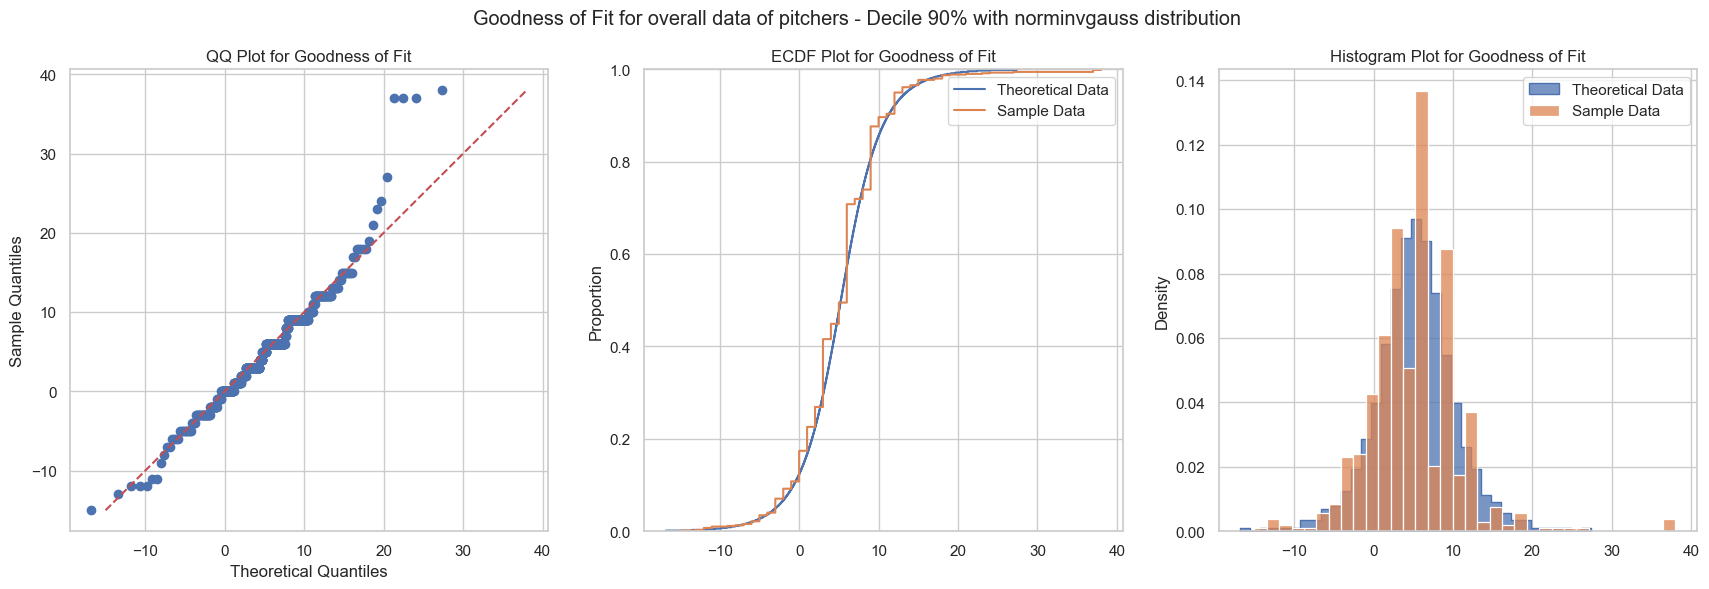

In [147]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(80, 90]'], 
    distribution_name="norminvgauss", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 90% with norminvgauss distribution"
)

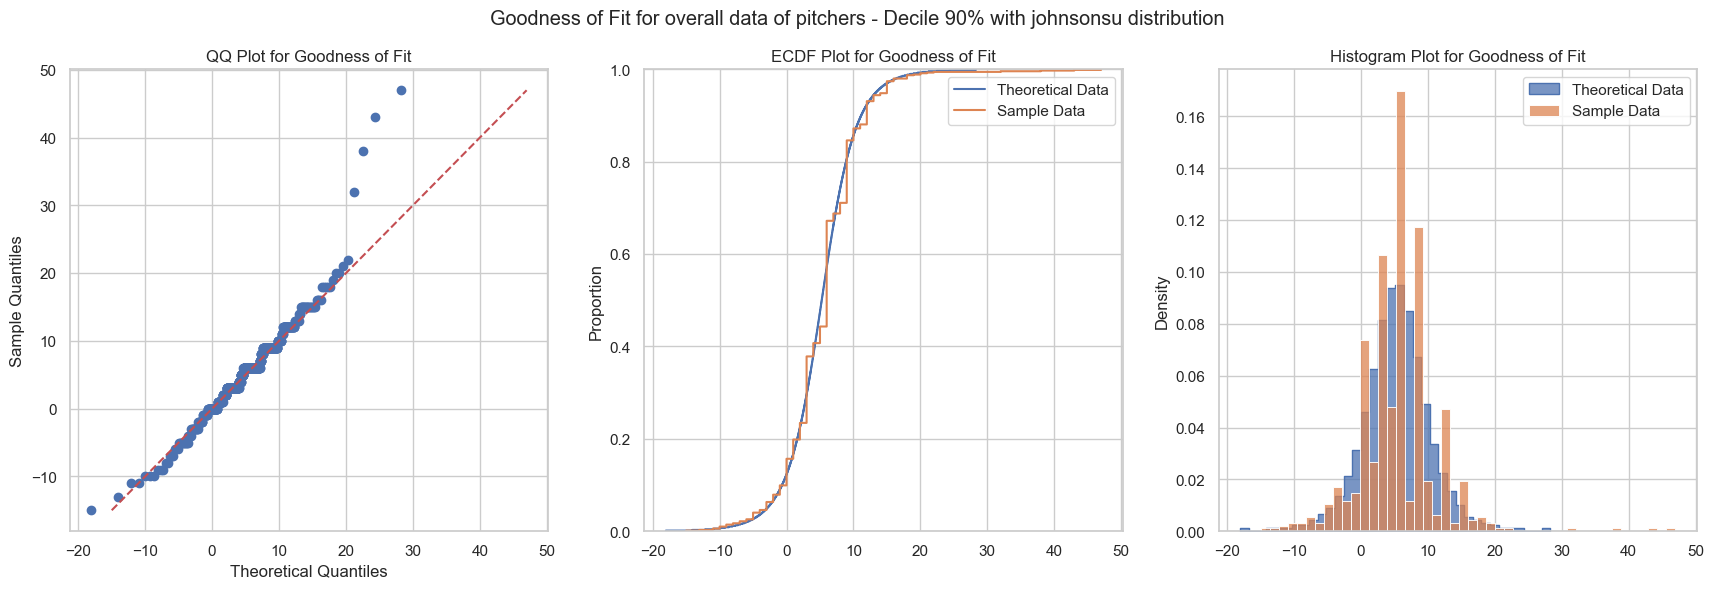

In [148]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(80, 90]'], 
    distribution_name="johnsonsu", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 90% with johnsonsu distribution"
)

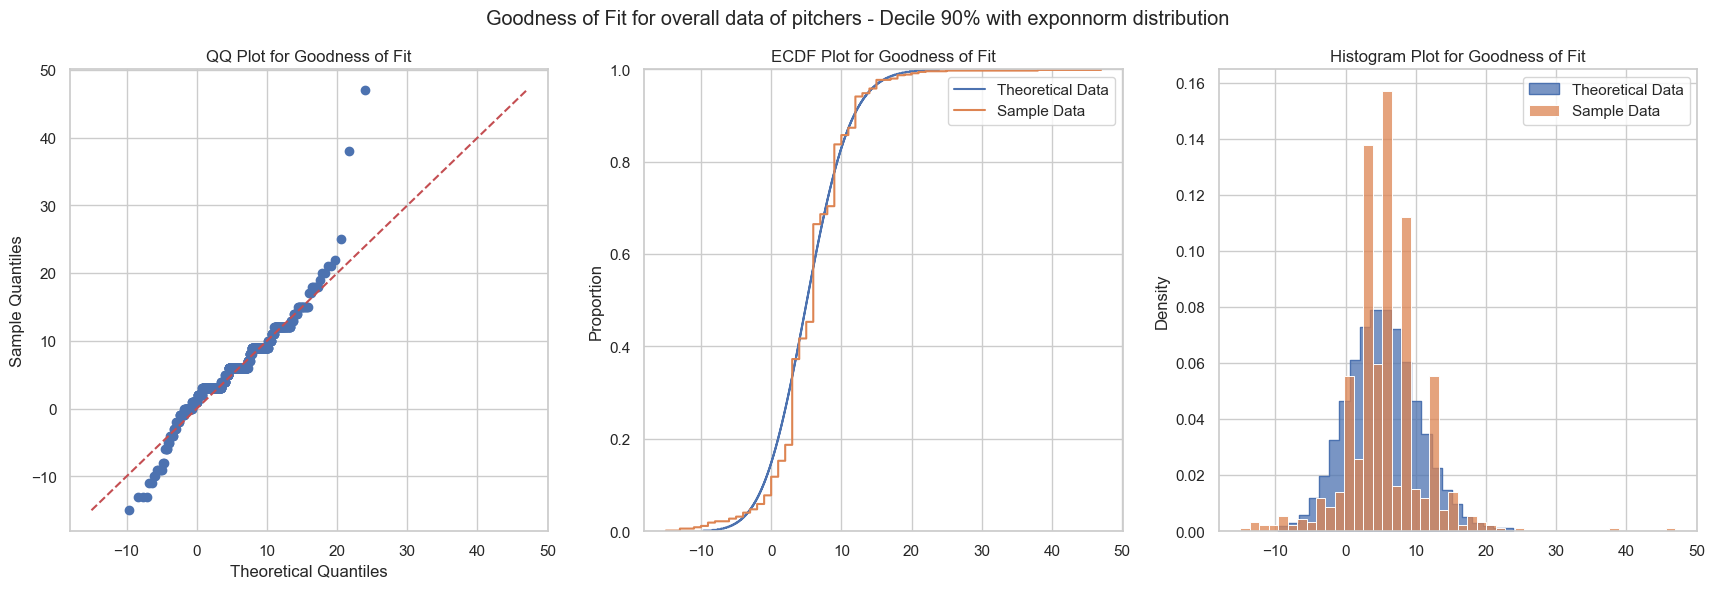

In [149]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(80, 90]'], 
    distribution_name="exponnorm", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 90% with exponnorm distribution"
)

##### **Decile 100%**

In [150]:
fitters['(90, 100]'].summary(sort_by="ks_statistic", top_n=10)

distribution  squared_error          aic          bic  \
exponnorm          exponnorm       0.251939  1091.619335  1112.195720   
norminvgauss    norminvgauss       0.251069   945.516144   972.951325   
johnsonsu          johnsonsu       0.250917   942.856654   970.291834   
genhyperbolic  genhyperbolic       0.250491   933.939794   968.233769   

               kullberg_divergence  ks_statistic    ks_p_value  \
exponnorm                      inf      0.118591  1.120965e-86   
norminvgauss                   inf      0.120329  3.120727e-89   
johnsonsu                      inf      0.121240  1.382151e-90   
genhyperbolic                  inf      0.604488  0.000000e+00   

                                                   fitted_params  
exponnorm      {'K': 0.3961300605193838, 'loc': 3.64165669145...  
norminvgauss   {'a': 1.575044108002518, 'b': -0.0674482767668...  
johnsonsu      {'a': 0.07787416207338335, 'b': 1.710865167893...  
genhyperbolic  {'p': 1.3565011001215477, 'a': 2.0966507597039...

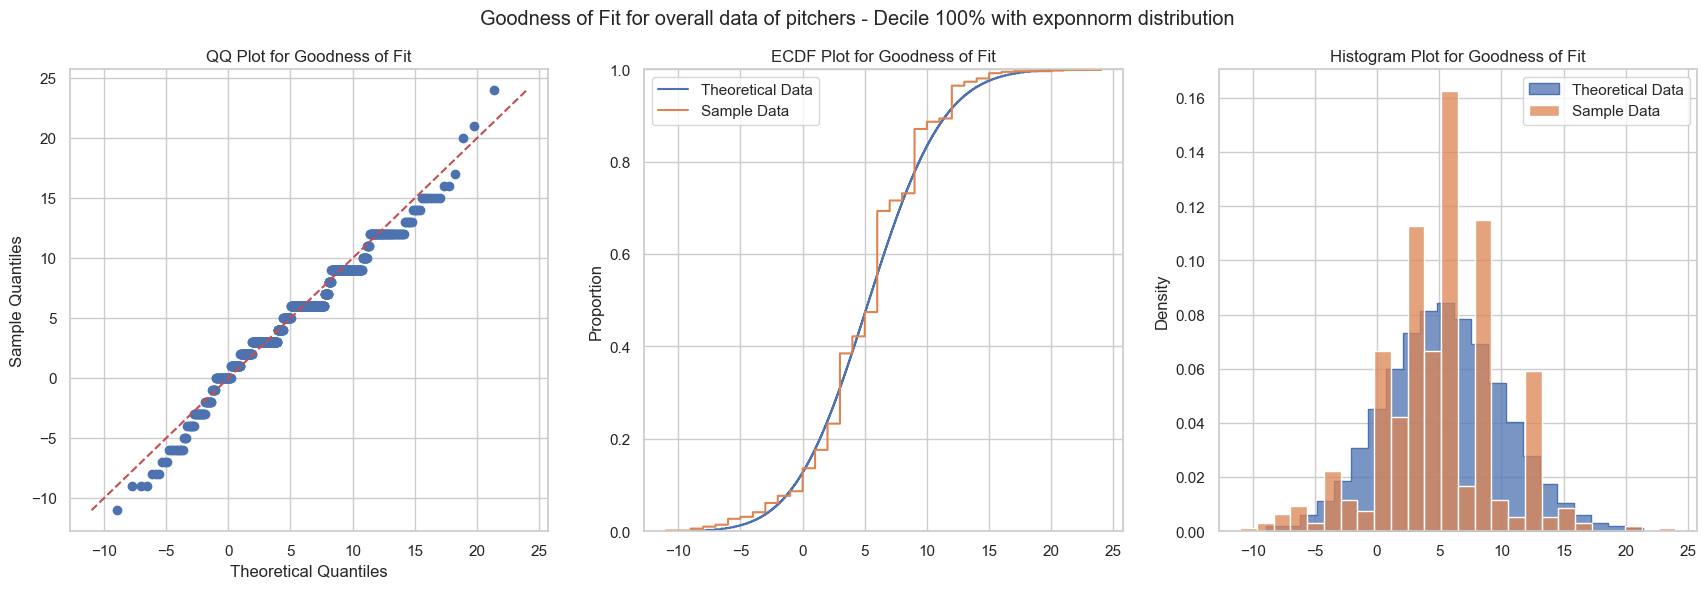

In [151]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(90, 100]'], 
    distribution_name="exponnorm", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 100% with exponnorm distribution"
)

### Pitchers dataframe for distributions

In [152]:
pitchers_df.head()

game_info__bigdataball_dataset game_info__game_id game_info__date  \
0        MLB 2022 Regular Season    44658-MIL@CHC-1      2022-04-07   
1        MLB 2022 Regular Season    44664-MIL@BAL-1      2022-04-13   
2        MLB 2022 Regular Season    44670-PIT@MIL-1      2022-04-19   
3        MLB 2022 Regular Season    44676-SFG@MIL-1      2022-04-25   
4        MLB 2022 Regular Season    44682-CHC@MIL-1      2022-05-01   

   player_info__player_id player_info__player_name  player_info__team  \
0                669203.0            Corbin Burnes  Milwaukee Brewers   
1                669203.0            Corbin Burnes  Milwaukee Brewers   
2                669203.0            Corbin Burnes  Milwaukee Brewers   
3                669203.0            Corbin Burnes  Milwaukee Brewers   
4                669203.0            Corbin Burnes  Milwaukee Brewers   

  player_info__opponent player_info__venue position__draftkings  \
0          Chicago Cubs               Road                  NaN   
1     Baltimore Orioles               Road                  NaN   
2    Pittsburgh Pirates               Home                    P   
3  San Francisco Giants               Home                    P   
4          Chicago Cubs               Home                    P   

  position__fanduel  ... fantasy_points__draftkings fantasy_points__fanduel  \
0                 P  ...                        NaN                    18.0   
1                 P  ...                        NaN                    49.0   
2                 P  ...                      33.35                    55.0   
3                 P  ...                      34.00                    57.0   
4                 P  ...                      28.75                    49.0   

   fantasy_points__yahoo  game_info__game_type  year  number_of_observations  \
0                    NaN        regular-season  2022                     105   
1                   32.5        regular-season  2022                     105   
2                   37.4        regular-season  2022                     105   
3                    NaN        regular-season  2022                     105   
4                   32.5        regular-season  2022                     105   

   cumsum_observations total_observations  cumulative_proportion  decile_group  
0                40565              69587              58.293934      (50, 60]  
1                40565              69587              58.293934      (50, 60]  
2                40565              69587              58.293934      (50, 60]  
3                40565              69587              58.293934      (50, 60]  
4                40565              69587              58.293934      (50, 60]  

[5 rows x 24 columns]

In [153]:
pitchers_distributions_df = pitchers_df\
.assign(
    row_number=pitchers_df\
    .groupby('player_info__player_id')['game_info__date']\
    .rank(method='first', ascending = False).astype(int)
).query("row_number == 1")[["player_info__player_id", "decile_group", "position__fanduel"]]

In [155]:
pitchers_distributions_df.head()

player_info__player_id decile_group position__fanduel
32                 669203.0     (50, 60]                 P
130                676879.0     (10, 20]                 P
156                664776.0     (10, 20]                 P
201                543294.0     (40, 50]                 P
312                596057.0     (70, 80]                 P

In [156]:
deciles_distributions = pd.DataFrame(
    [
        {"decile_group": "(0, 10]", "decile_distribution": "exponnorm", "decile_parameters": str(fitters["(0, 10]"].get_distribution_parameters("exponnorm"))},
        {"decile_group": "(10, 20]", "decile_distribution": "exponnorm", "decile_parameters": str(fitters["(10, 20]"].get_distribution_parameters("exponnorm"))}, 
        {"decile_group": "(20, 30]", "decile_distribution": "exponnorm", "decile_parameters": str(fitters["(20, 30]"].get_distribution_parameters("exponnorm"))},
        {"decile_group": "(30, 40]", "decile_distribution": "exponnorm", "decile_parameters": str(fitters["(30, 40]"].get_distribution_parameters("exponnorm"))},
        {"decile_group": "(40, 50]", "decile_distribution": "exponnorm", "decile_parameters": str(fitters["(40, 50]"].get_distribution_parameters("exponnorm"))},
        {"decile_group": "(50, 60]", "decile_distribution": "exponnorm", "decile_parameters": str(fitters["(50, 60]"].get_distribution_parameters("exponnorm"))},
        {"decile_group": "(60, 70]", "decile_distribution": "genhyperbolic", "decile_parameters": str(fitters["(60, 70]"].get_distribution_parameters("exponnorm"))},
        {"decile_group": "(70, 80]", "decile_distribution": "genhyperbolic", "decile_parameters": str(fitters["(70, 80]"].get_distribution_parameters("exponnorm"))},
        {"decile_group": "(80, 90]", "decile_distribution": "norminvgauss", "decile_parameters": str(fitters["(80, 90]"].get_distribution_parameters("exponnorm"))},
        {"decile_group": "(90, 100]", "decile_distribution": "exponnorm", "decile_parameters": str(fitters["(90, 100]"].get_distribution_parameters("exponnorm"))},
    ]
)

In [157]:
pitchers_distributions_df = pitchers_distributions_df.assign(
    general_distribution="exponnorm",
    general_parameters=str(pitchers_distribution_fitter.get_distribution_parameters("exponnorm"))
).merge(right=deciles_distributions)

In [203]:
pitchers_distributions_df.shape

(1257, 7)

In [201]:
pitchers_distributions_df

player_info__player_id decile_group position__fanduel  \
0                   669203.0     (50, 60]                 P   
1                   425794.0     (50, 60]                 P   
2                   571578.0     (50, 60]                 P   
3                   608723.0     (50, 60]                 P   
4                   650671.0     (50, 60]                 P   
...                      ...          ...               ...   
1252                502578.0      (0, 10]                 P   
1253                622795.0      (0, 10]                 P   
1254                543343.0      (0, 10]                 P   
1255                621086.0      (0, 10]                 P   
1256                575070.0      (0, 10]                 P   

     general_distribution                                 general_parameters  \
0               exponnorm  {'K': 2.4651282777212216, 'loc': -0.6249902588...   
1               exponnorm  {'K': 2.4651282777212216, 'loc': -0.6249902588...   
2               exponnorm  {'K': 2.4651282777212216, 'loc': -0.6249902588...   
3               exponnorm  {'K': 2.4651282777212216, 'loc': -0.6249902588...   
4               exponnorm  {'K': 2.4651282777212216, 'loc': -0.6249902588...   
...                   ...                                                ...   
1252            exponnorm  {'K': 2.4651282777212216, 'loc': -0.6249902588...   
1253            exponnorm  {'K': 2.4651282777212216, 'loc': -0.6249902588...   
1254            exponnorm  {'K': 2.4651282777212216, 'loc': -0.6249902588...   
1255            exponnorm  {'K': 2.4651282777212216, 'loc': -0.6249902588...   
1256            exponnorm  {'K': 2.4651282777212216, 'loc': -0.6249902588...   

     decile_distribution                                  decile_parameters  
0              exponnorm  {'K': 3.590286445683425, 'loc': -1.19296190023...  
1              exponnorm  {'K': 3.590286445683425, 'loc': -1.19296190023...  
2              exponnorm  {'K': 3.590286445683425, 'loc': -1.19296190023...  
3              exponnorm  {'K': 3.590286445683425, 'loc': -1.19296190023...  
4              exponnorm  {'K': 3.590286445683425, 'loc': -1.19296190023...  
...                  ...                                                ...  
1252           exponnorm  {'K': 1.936953865172137, 'loc': -1.15432286206...  
1253           exponnorm  {'K': 1.936953865172137, 'loc': -1.15432286206...  
1254           exponnorm  {'K': 1.936953865172137, 'loc': -1.15432286206...  
1255           exponnorm  {'K': 1.936953865172137, 'loc': -1.15432286206...  
1256           exponnorm  {'K': 1.936953865172137, 'loc': -1.15432286206...  

[1257 rows x 7 columns]

## OF - Outfield

In [159]:
outfield_df = cleaned_mlb_df[
    (cleaned_mlb_df.position__fanduel == "OF") & 
    (~cleaned_mlb_df['fantasy_points__fanduel'].isna())
    ]

In [160]:
outfield_df.size

1117333

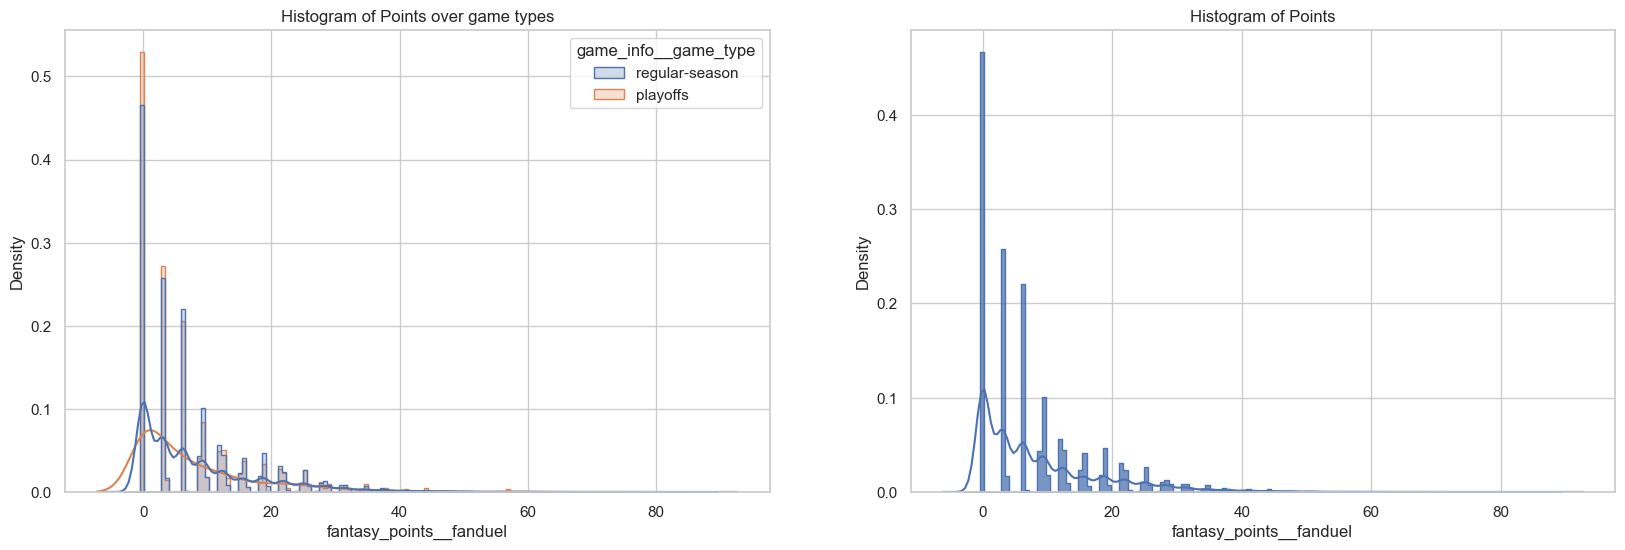

In [162]:
# Setting up style for better visualization
sns.set(style="whitegrid")

# Plotting the histogram
fig, ax = plt.subplots(ncols=2, figsize=(20, 6))

sns.kdeplot(
    data=outfield_df, 
    x='fantasy_points__fanduel', 
    hue='game_info__game_type', 
    common_norm=False,
    ax=ax[0]
)

sns.histplot(
    data=outfield_df, 
    x='fantasy_points__fanduel', 
    hue='game_info__game_type', 
    element='step', 
    stat='density', 
    common_norm=False,
    ax=ax[0]
)

ax[0].set_title("Histogram of Points over game types")

sns.kdeplot(
    data=outfield_df, 
    x='fantasy_points__fanduel',  
    common_norm=False,
    ax=ax[1]
)

sns.histplot(
    data=outfield_df, 
    x='fantasy_points__fanduel', 
    element='step', 
    stat='density', 
    common_norm=False,
    ax=ax[1]
)

ax[1].set_title('Histogram of Points')

plt.show()

### Adding Statistics

In [186]:
statistics_by_outfield = outfield_df\
.groupby('player_info__player_id')\
.agg(number_of_observations=pd.NamedAgg("player_info__player_id", "count"))\
.sort_values(by=['number_of_observations'])\
.pipe(lambda df: df.assign(
    cumsum_observations=df.number_of_observations.cumsum(), 
    total_observations=df.number_of_observations.sum()
))\
.pipe(lambda df: df.assign(
    cumulative_proportion=(df.cumsum_observations / df.total_observations) * 100))\
.reset_index()\
.pipe(lambda df: df.assign(
    decile_group=pd.cut(df.cumulative_proportion, bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]).astype("str")
))

In [187]:
outfield_df = outfield_df.merge(right=statistics_by_outfield)

In [188]:
statistics_by_outfield.head()

player_info__player_id  number_of_observations  cumsum_observations  \
0                675986.0                       1                    1   
1                666783.0                       1                    2   
2                657424.0                       1                    3   
3                518649.0                       1                    4   
4                664011.0                       1                    5   

   total_observations  cumulative_proportion decile_group  
0               58807               0.001700      (0, 10]  
1               58807               0.003401      (0, 10]  
2               58807               0.005101      (0, 10]  
3               58807               0.006802      (0, 10]  
4               58807               0.008502      (0, 10]

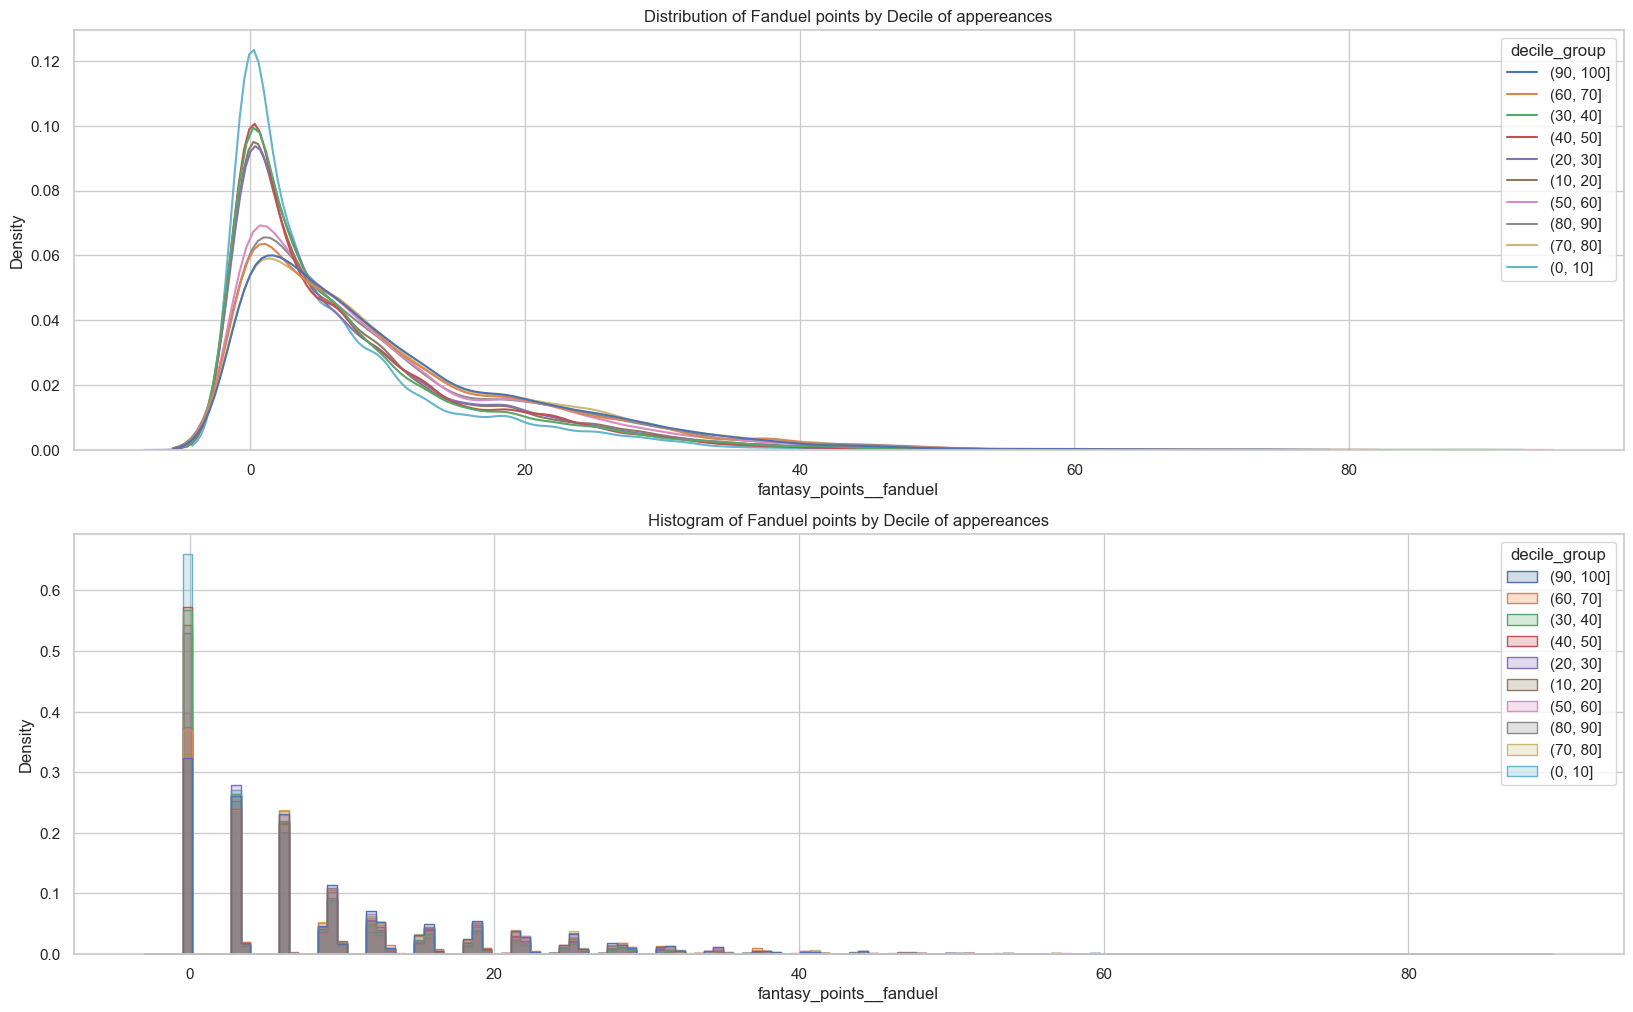

In [189]:
fig, ax = plt.subplots(nrows=2, figsize=(20, 12))

sns.kdeplot(
    data=outfield_df, 
    x='fantasy_points__fanduel', 
    hue='decile_group', 
    common_norm=False,
    ax=ax[0],
)

ax[0].set_title('Distribution of Fanduel points by Decile of appereances')

sns.histplot(
    data=outfield_df, 
    x='fantasy_points__fanduel', 
    element='step', 
    stat='density', 
    hue='decile_group', 
    common_norm=False, # Helps on visualization,
    ax=ax[1]
)

ax[1].set_title('Histogram of Fanduel points by Decile of appereances')

plt.show()

### Fitting a general distribution

In [191]:
data = outfield_df['fantasy_points__fanduel']

#### Fitting

In [192]:
outfield_distribution_fitter = DistributionFitter(
    distributions=[dist for dist in get_distributions() if dist not in ["levy_stable", "studentized_range", "erlang", "lognorm", "loguniform"]], 
    bins=sturges_bins(data)
)

In [193]:
outfield_distribution_fitter.fit(data)

INFO:statistical_simulation_tools.distribution_fitter:Fitting distribution: alpha
INFO:statistical_simulation_tools.distribution_fitter:Fitting distribution: anglit
INFO:statistical_simulation_tools.distribution_fitter:Fitting distribution: arcsine
INFO:statistical_simulation_tools.distribution_fitter:Fitting distribution: argus
INFO:statistical_simulation_tools.distribution_fitter:Fitting distribution: beta
/opt/miniconda3/envs/statistical-simulation/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:719: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
INFO:statistical_simulation_tools.distribution_fitter:Fitting distribution: betaprime
INFO:statistical_simulation_tools.distribution_fitter:Fitting distribution: bradford
INFO:statistical_simulation_tools.distribution_fitter:Fitting distribution: burr
INFO:statistical_simulation_tools.distribution_fitter:Fitting distribution: burr12
INFO:statistical_simulation_t

In [194]:
outfield_distribution_fitter.summary(sort_by="ks_statistic", top_n=15)

distribution  squared_error          aic          bic  \
nakagami                nakagami       0.784411  4592.509980  4619.456029   
chi                          chi       0.784411  4592.518641  4619.464690   
truncnorm              truncnorm       0.784858  5354.930406  5390.858471   
genhalflogistic  genhalflogistic       0.784716  4771.424943  4798.370992   
gibrat                    gibrat       0.759636  2896.511527  2914.475560   
foldnorm                foldnorm       0.785006  4497.889461  4524.835510   
halfnorm                halfnorm       0.784988  4500.112420  4518.076452   
genlogistic          genlogistic       0.787315  4062.598451  4089.544500   
gumbel_r                gumbel_r       0.787361  4060.564303  4078.528335   
rel_breitwigner  rel_breitwigner       0.783562  3223.469545  3250.415593   
gamma                      gamma       0.772027  3646.047952  3672.994000   
pearson3                pearson3       0.772027  3646.040148  3672.986197   
gengamma                gengamma       0.769004  3441.373536  3477.301601   
beta                        beta       0.772238  3680.367686  3716.295751   
moyal                      moyal       0.781172  3830.238195  3848.202228   

                 kullberg_divergence  ks_statistic  ks_p_value  \
nakagami                         inf      0.149433         0.0   
chi                              inf      0.149434         0.0   
truncnorm                        inf      0.153580         0.0   
genhalflogistic                  inf      0.154395         0.0   
gibrat                           inf      0.157284         0.0   
foldnorm                         inf      0.158106         0.0   
halfnorm                         inf      0.158227         0.0   
genlogistic                      inf      0.163445         0.0   
gumbel_r                         inf      0.163851         0.0   
rel_breitwigner                  inf      0.165310         0.0   
gamma                            inf      0.166310         0.0   
pearson3                         inf      0.166311         0.0   
gengamma                         inf      0.168236         0.0   
beta                             inf      0.169237         0.0   
moyal                            inf      0.178795         0.0   

                                                     fitted_params  
nakagami         {'nu': 0.5212580306386961, 'loc': -3.000015922...  
chi              {'df': 1.0425184745730376, 'loc': -3.000015773...  
truncnorm        {'a': -0.28186912299728095, 'b': 44.3302422939...  
genhalflogistic  {'c': 0.10441162285276673, 'loc': -3.000000340...  
gibrat           {'loc': -3.001723840453023, 'scale': 8.2054518...  
foldnorm         {'c': 0.06270420441166503, 'loc': -3.000000001...  
halfnorm         {'loc': -3.000000000808708, 'scale': 15.026432...  
genlogistic      {'c': 1798.9977634821344, 'loc': -41.867387743...  
gumbel_r         {'loc': 4.355773850172532, 'scale': 6.16576138...  
rel_breitwigner  {'rho': 0.0017110809634040486, 'loc': -3.00031...  
gamma            {'a': 1.6586120127453836, 'loc': -3.0003017578...  
pearson3         {'skew': 1.5529482713270555, 'loc': 8.41929675...  
gengamma         {'a': 2.684976646757232, 'c': 0.75722248640223...  
beta             {'a': 1.6870930378132227, 'b': 1100.8690255339...  
moyal            {'loc': 3.2359522211264196, 'scale': 3.5956718...

#### Validation

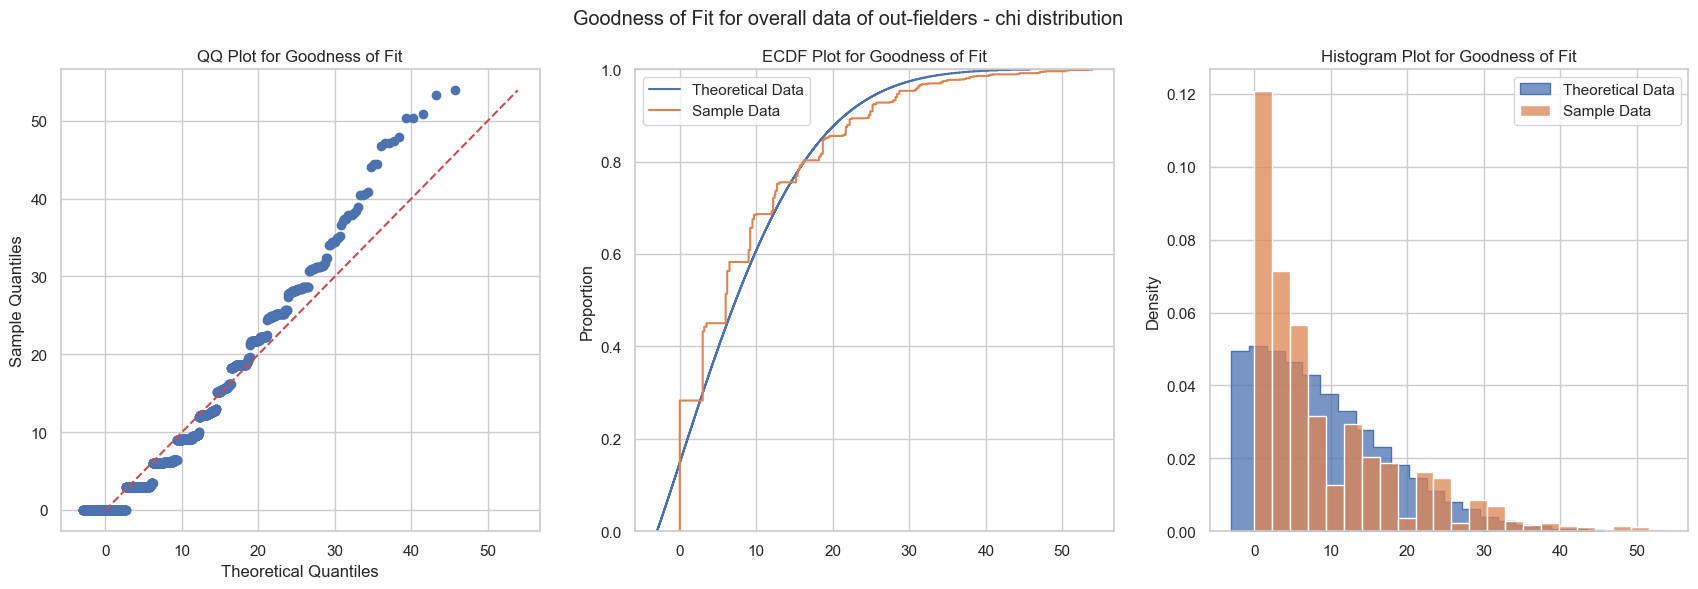

In [239]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=outfield_distribution_fitter, 
    distribution_name="chi", 
    sample_proportion=0.02, 
    suptitle="Goodness of Fit for overall data of out-fielders - chi distribution"
)

In [237]:
cleaned_mlb_df.player_info__team.unique()

array(['Milwaukee Brewers', 'Chicago Cubs', 'Cleveland Guardians',
       'Kansas City Royals', 'Pittsburgh Pirates', 'St. Louis Cardinals',
       'New York Mets', 'Washington Nationals', 'Cincinnati Reds',
       'Atlanta Braves', 'Houston Astros', 'Los Angeles Angels',
       'San Diego Padres', 'Arizona Diamondbacks', 'Boston Red Sox',
       'New York Yankees', 'Chicago White Sox', 'Detroit Tigers',
       'Oakland Athletics', 'Philadelphia Phillies', 'Baltimore Orioles',
       'Tampa Bay Rays', 'Los Angeles Dodgers', 'Colorado Rockies',
       'Seattle Mariners', 'Minnesota Twins', 'Miami Marlins',
       'San Francisco Giants', 'Texas Rangers', 'Toronto Blue Jays',
       'Cleveland Indians'], dtype=object)

In [217]:
scipy.stats.norm.rvs(loc=10, scale=1)

10.293962088071655

In [241]:
get_frequencies(pitchers_df, "player_info__player_name")

player_info__player_name  frequency
774               Luis Garcia        237
519              Jake Diekman        236
23              Adam Ottavino        234
706             Kenley Jansen        234
461              Hector Neris        231
...                       ...        ...
1023            Ryan O'Rourke          1
1232            Xzavion Curry          1
975           Ricardo Sanchez          1
974             Ricardo Pinto          1
1087  Simeon Woods Richardson          1

[1274 rows x 2 columns]

In [255]:
scipy.stats.exponnorm.fit(pitchers_df.query("player_info__player_name=='Luis Garcia'")['fantasy_points__fanduel'])

(3.072841321213799, -1.2054014536877489, 3.615006017216783)

In [218]:
scipy.stats.exponnorm.fit(pitchers_df[])

0.3411103109138838

In [ ]:
def fit_exponnorm(data: np.ndarray, default_parameters: dict) -> object:
    if len(data) > 30:
        return scipy.stats.exponnorm.fit(data)
    else:
        return default_parameters

In [ ]:
scipy.stats.exponnorm()

In [235]:
scipy.stats.exponnorm.rvs(**pitchers_distribution_fitter.get_distribution_parameters("exponnorm"))

7.495060947341731

In [ ]:
scipy.stats.exponnorm.rvs(pitchers_df.query("player_info__player_name=='Luis Garcia'")['parameters'])

In [200]:
lambda_estimated = 1 / pitchers_distribution_fitter._data.mean()

pitchers_distribution_fitter._data.mean() + lambda_estimated

10.114326591911334